In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time
from keras.models import load_model
from keras import backend as K
import keras
'''
Compatible with tensorflow backend
gamma entre más alto más tolerante (queremos un gamma chico pero no demasiado! 0.25 - 5)
alpha pesos por clase (weights)
'''
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE


The history saving thread hit an unexpected error (OperationalError('no such table: history',)).History will not be written to the database.


Using TensorFlow backend.


In [2]:
#'baselines_4/cnn1_ce10_100.h5'
print ("Nh\t\t| IH\t\t| PH\t\t| SH\t\t| F-Macro")
print (0.92792793 ,'\t',0. ,'\t\t',        0.,'\t\t',         0.84057971,'\t',    0.4421269095182139)
#('baselines_4/cnn1_focal10_100.h5')
print (0.78674791,'\t', 0.13793103 ,'\t',0.09756098 ,'\t',0.56389987,'\t',   0.396534945974999  )
#('baselines_4/rnn_simple_100_focal15.h5')
print (0.9197861  ,'\t',0.10884354 ,'\t',0.0729927  ,'\t',0.78439425,'\t',  0.47150414622873116)
#('baselines_4/rnn1_100_focal15.h5')
print (0.92418033,'\t', 0.14876033 ,'\t',0.17073171 ,'\t',0.85254692,'\t',  0.5240548206636296)
#('baselines_4/rnn2_100_focal15.h5')
print (0.9054658 ,'\t', 0.13714286 ,'\t',0.10909091 ,'\t',0.74418605,'\t',  0.47397140213787825)
#('baselines_4/rnn3_100_focal15.h5')
print (0.78454333 ,'\t',0.10327022,'\t', 0.10362694 ,'\t',0.71553611,'\t', 0.42674414932927196)
#('baselines_4/cnn1_focal10_100_g3_100.h5')
print (0.91473851 ,'\t',0. ,'\t\t',        0.09386282 ,'\t',0.52150538,'\t',    0.38252667563241805)

#pasan a transformer: 1,2,7,8,9,10,12

Nh		| IH		| PH		| SH		| F-Macro
0.92792793 	 0.0 		 0.0 		 0.84057971 	 0.4421269095182139
0.78674791 	 0.13793103 	 0.09756098 	 0.56389987 	 0.396534945974999
0.9197861 	 0.10884354 	 0.0729927 	 0.78439425 	 0.47150414622873116
0.92418033 	 0.14876033 	 0.17073171 	 0.85254692 	 0.5240548206636296
0.9054658 	 0.13714286 	 0.10909091 	 0.74418605 	 0.47397140213787825
0.78454333 	 0.10327022 	 0.10362694 	 0.71553611 	 0.42674414932927196
0.91473851 	 0.0 		 0.09386282 	 0.52150538 	 0.38252667563241805


In [3]:
cnn_100_c = load_model('baselines_4/cnn1_ce10_100.h5')
#cnn_100_f = load_model('baselines_4/cnn1_focal10_100.h5')
gru_s = load_model('baselines_4/rnn_simple_100_focal15.h5')
gru1 = load_model('baselines_4/rnn1_100_focal15.h5')
gru2 = load_model('baselines_4/rnn2_100_focal15.h5')
#gru3 = load_model('baselines_4/rnn3_100_focal15.h5')
#cnn_100_f3 = load_model('baselines_4/cnn1_focal10_100_g3_100.h5')


list_models=['cnn_100_c', 'gru_s', 'gru1', 'gru2']
index_models=np.arange(4)
dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
modelos=[cnn_100_c, gru_s, gru1, gru2]
ind=np.arange(4)
dict_trainingModel=dict((key, value) for (key, value) in zip(ind,modelos))

In [5]:
predicciones_all=[]
X_train=np.load("matrices/X_train_4.npy")
X_train_rnn=np.load("../../../respSIMAH/X_train_rnn_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all.append(dict_trainingModel[i].predict(X_train, batch_size=bs))
    else:
        predicciones_all.append(dict_trainingModel[i].predict(X_train_rnn, batch_size=bs))
        
predicciones_all_val=[]
X_val=np.load("matrices/X_val_ig_4.npy")
X_val_rnn=np.load("matrices/X_val_rnn_ig_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones val del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all_val.append(dict_trainingModel[i].predict(X_val, batch_size=bs))
    else:
        predicciones_all_val.append(dict_trainingModel[i].predict(X_val_rnn, batch_size=bs))
        

Agregando predicciones del modelo cnn_100_c
Agregando predicciones del modelo gru_s
Agregando predicciones del modelo gru1
Agregando predicciones del modelo gru2
Agregando predicciones val del modelo cnn_100_c
Agregando predicciones val del modelo gru_s
Agregando predicciones val del modelo gru1
Agregando predicciones val del modelo gru2


In [6]:
predicciones_all_test=[]
X_test=np.load("matrices/X_test_ig_4.npy")
X_test_rnn=np.load("matrices/X_test_rnn_4.npy")

bs=32
for i in dict_trainingModel.keys(): 
    print ("Agregando predicciones test del modelo", dict_models[i])
    a_evaluar=dict_models[i]
    if a_evaluar[:3]!='gru':
        predicciones_all_test.append(dict_trainingModel[i].predict(X_test, batch_size=bs))
    else:
        predicciones_all_test.append(dict_trainingModel[i].predict(X_test_rnn, batch_size=bs))

Agregando predicciones test del modelo cnn_100_c
Agregando predicciones test del modelo gru_s
Agregando predicciones test del modelo gru1
Agregando predicciones test del modelo gru2


In [7]:
matrix=np.asarray(predicciones_all)
print (matrix.shape)
matrix_val=np.asarray(predicciones_all_val)
print (matrix_val.shape)
matrix_test=np.asarray(predicciones_all_test)
print (matrix_test.shape)

(4, 6374, 4)
(4, 2125, 4)
(4, 2123, 4)


In [8]:
new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)
new_matrix.shape

(4, 10622, 4)

In [9]:
class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        #print ("aux_size en dummy emb", aux.shape, aux)
        new_x= aux - np.ones(aux.shape)#cambiar aqui! (ver hojita de cuaderno)
        new_x= torch.from_numpy(new_x)
        #print ("nuevo aux con el menos 1s (clase 1 en ind 0 y los ids desde 5 ind)", aux)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_text=x.data[:,0][:,None,:]
        x_machines=x.data[:,1:]
        
        x_return = x_machines* x_text
        return self.dropout(x_return)
    
class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)

In [24]:
def data_gen(batch_size,mode,n_machines,new_matrix):  
    """ESTA FUNCION DEBERÁ RETORNAR MATRICES DE TAMAÑO BATCH_SIZE * TW,M1,M2,M3,M4,M5,M6
    CADA EJEMPLO DEBERÁ SER ESTILO [ID_T, 1,2,1,2,1,2] SIENDO 1 CUANDO LA CLASE PREDICHA ES LA 0
    2 PARA CLASE PREDICHA 1, ETC. ID_T DEBEŔA INICIAR EN 5 PARA REFERIRSE AL PRIMER TW (EL PRIMERO DE TRAIN)"""
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)
        objs=df_train['Unnamed: 0'].values
        objs=[obj+5 for obj in objs]
        labels=np.load("matrices/y_train_num_4.npy")
        labels=labels+ np.ones(labels.shape)       
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]
        np.random.shuffle(x_list)
        objs=df_val['Unnamed: 0'].values        
        objs=[obj+5 for obj in objs]
        labels=np.load("matrices/y_val_num_4.npy")
        labels=labels+ np.ones(labels.shape) 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        #np.random.shuffle(x_list)
        #print ("X LIST SIN SHUFFLE", x_list)
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=np.arange(total, total+max_objs)
        objs=[obj+5 for obj in objs]
        
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
    
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for exam in batch:
            if mode=='Train':
                temp2=[objs[exam]] ### obj evaluado en maquinas
            elif mode=='Val':
                temp2=[objs[exam-matrix.shape[1]]] 
            else:
                temp2=[objs[exam-matrix.shape[1]-matrix_val.shape[1]]]                
            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(new_matrix[m][exam])+1] 
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for batch in new_x_data:
            temp_y=[]
            for exam in batch:
                q=exam[0]
                indice=match(objs, q)    
                temp_y.append([labels[indice]])       
            y_data.append(temp_y)
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    
    if mode=='Train' or mode=='Val':
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
    else:
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)

In [25]:
df_train=pd.read_csv("../Train_data_compeition.csv")
df_val=pd.read_csv("../Validation_data_competition.csv")
df_test=pd.read_csv("../testset-competition.csv")
df_train.head()

Unnamed: 0                                      tweet_content  harassment  \
0           0  pics mexican school girl naked melanie safka f...           1   
1           1  RT shereiqns Having curly hair is a gotdamn ch...           0   
2           2   BreakingNews 7 Unexplained Prisoners Deaths M...           0   
3           3   girl dirty quarterback latino pokemon young h...           1   
4           4   miliondollameat sexting n ngirl daddy n nme l...           1   

   IndirectH  PhysicalH  SexualH  
0          0          0        1  
1          0          0        0  
2          0          0        0  
3          0          0        1  
4          0          0        1

In [26]:
Ks=np.load("../Orthogonals_768.npy")
print (Ks.shape)
random=np.random.randint(Ks.shape[0], size=4)
K_list=[Ks[k] for k in random]
print (np.asarray(K_list).shape)
len(K_list)

(768, 768)
(4, 768)


4

# por qué parte en 5?

In [27]:
K_list_ext=K_list
objs_train=df_train['Unnamed: 0'].values
objs_val=df_val['Unnamed: 0'].values
objs_test=np.arange(df_test.shape[0])
tope=len(objs_train)+len(objs_val)
objs_test=[elem+tope for elem in objs_test]
print (objs_train.shape)
print (objs_val.shape)
print (len(objs_test))
#print (objs_test.shape)
llaves=np.concatenate([objs_train,objs_val,objs_test])
#valores=np.arange(5, len(objs_train)+len(objs_val)+len(objs_test)+5)
len(llaves)

(6374,)
(2125,)
2123


10622

In [28]:
#dict_IDObj=dict((key, value) for (key, value) in zip(llaves,valores))
#dict_ObjID=dict((key, value) for (key, value) in zip(valores,llaves))
#len(dict_ObjID)

In [29]:
contador=0
for i in range(tope):
    vector=np.load("../../vectors/"+str(i)+".npy")
    K_list_ext.append(vector[0])
for i in range(len(objs_test)):
    vector=np.load("../../test_vectors/"+str(i)+".npy")
    K_list_ext.append(vector[0])
print ("largo de lista de vectores bert (considerando dummy clases)", len(K_list_ext))
    

largo de lista de vectores bert (considerando dummy clases) 10626


In [30]:
len(K_list_ext)

10626

In [31]:
K_list_new= np.asarray(K_list_ext, dtype='float32')
K_list_new.shape

(10626, 768)

In [32]:
def make_model_concat(target, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            total_datos = 0
            total_loss = 0
            total_acc=0
            total_fm1=0
            total_fs=0
            n_batches = 0
            cm_last=np.zeros((4,4))
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
                
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0
            total_fs += f1  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last

In [33]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of learners + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        #print ("Rate de Noam_opt", self._rate, self._step)
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):        
        y_new=(y.float()-torch.ones((y.shape[0],y.shape[1]))).int()
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    

# DESDE ACA

In [34]:
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])

y_train_har=np.load("matrices/y_train_num_4.npy")
print (y_train_har[:10])
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_har), y_train_har)
print (class_weights)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

[3 0 0 3 3 0 3 3 0 0]
[  0.43526359  28.97272727  20.96710526   0.61715724]


## Modelos

In [22]:
### Mejor caso a superar: 
print ("Nh\t\t| IH\t\t| PH\t\t| SH\t\t| F-Macro")
#('baselines_4/rnn1_100_focal15.h5')
print (0.92418033,'\t', 0.14876033 ,'\t',0.17073171 ,'\t',0.85254692,'\t',  0.5240548206636296)
#('baselines_4/rnn2_100_focal15.h5')
print (0.9054658 ,'\t', 0.13714286 ,'\t',0.10909091 ,'\t',0.74418605,'\t',  0.47397140213787825)

Nh		| IH		| PH		| SH		| F-Macro
0.92418033 	 0.14876033 	 0.17073171 	 0.85254692 	 0.5240548206636296
0.9054658 	 0.13714286 	 0.10909091 	 0.74418605 	 0.47397140213787825


In [22]:
V = 4
pesos = torch.from_numpy(class_weights).float()
print (pesos)
criterion = FocalLoss(weights=pesos)
model = make_model_concat(4, N=2,d_model=768, d_ff=128, h=4, dropout=0.3)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 500, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

hist_train_loss=[]
hist_train_acc=[]
hist_train_fma=[]
hist_val_loss=[]
hist_val_acc=[]
hist_val_fma=[]

for epoch in range(30):
    print ("")
    print (model_opt._rate)
    print ("")
    model.train()
    DATA=data_gen(35, 'Train', 4, new_matrix)
    loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
    hist_train_loss.append(loss_train)
    hist_train_acc.append(acc_train)
    hist_train_fma.append(fma_train)

    model.eval()
    loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
    print ("Validando Epoch",epoch)
    print ("loss_val:",loss_val)
    print ("Acc_val:",acc_val)
    print ("f_score_val:",fma_val)
    print ("f_score_val:",f_val_none)
    hist_val_loss.append(loss_val)
    hist_val_acc.append(acc_val)
    hist_val_fma.append(fma_val)

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
loss_val: tensor(2.3257)
Acc_val: tensor(0.8782, dtype=torch.float64)
f_score_val: tensor(0.4462, dtype=torch.float64)
f_score_val: tensor([0.9285, 0.0164, 0.0164, 0.8236], dtype=torch.float64)

0.0005906299602966311

Validando Epoch 1
loss_val: tensor(2.2796)
Acc_val: tensor(0.8782, dtype=torch.float64)
f_score_val: tensor(0.4633, dtype=torch.float64)
f_score_val: tensor([0.9300, 0.0574, 0.0328, 0.8330], dtype=torch.float64)

0.0011812599205932623

Validando Epoch 2
loss_val: tensor(2.1611)
Acc_val: tensor(0.8525, dtype=torch.float64)
f_score_val: tensor(0.4760, dtype=torch.float64)
f_score_val: tensor([0.9260, 0.0852, 0.0934, 0.7994], dtype=torch.float64)

0.0015400443144886933

Validando Epoch 3
loss_val: tensor(2.1672)
Acc_val: tensor(0.8595, dtype=torch.float64)
f_score_val: tensor(0.4750, dtype=torch.float64)
f_score_val: tensor([0.9271, 0.0721, 0.0831, 0.8176], dtype=torch.float6

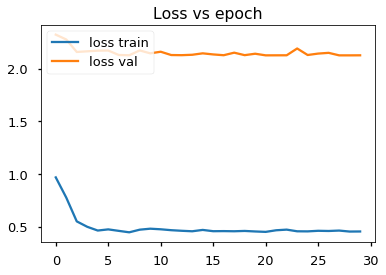

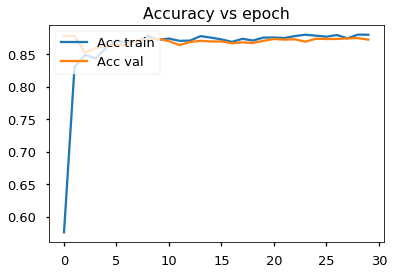

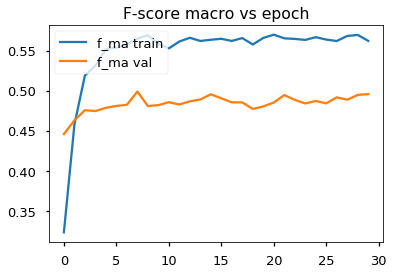

In [23]:
plt.plot(hist_train_loss, label='loss train')
plt.plot(hist_val_loss,label='loss val')
plt.legend(loc='upper left')
plt.title("Loss vs epoch")
plt.show()

plt.plot(hist_train_acc, label='Acc train')
plt.plot(hist_val_acc, label='Acc val')
plt.legend(loc='upper left')
plt.title("Accuracy vs epoch")
plt.show()

plt.plot(hist_train_fma, label='f_ma train')
plt.plot(hist_val_fma, label='f_ma val')
plt.legend(loc='upper left')
plt.title("F-score macro vs epoch")
plt.show()

### Testing model

Testing
SE TUVIERON QUE REPETIR 12 EJEMPLOS
(2135,)
Counter({0: 1651, 3: 333, 1: 79, 2: 72})


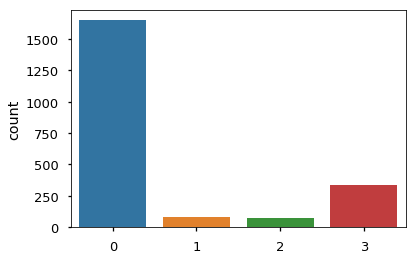

In [28]:
model.eval()
print ("Testing")
predicciones = run_epoch(data_gen(35, 'Test', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones=np.concatenate(predicciones, axis=-1)
print (predicciones.shape)
print (Counter(predicciones))
sns.countplot(predicciones)

In [29]:
model.eval()
print ("Validando")
loss_val, acc_val,fma_val, f_val_none, cm_val = run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
print ("Validando Epoch",epoch)
print ("loss_val:",loss_val)
print ("Acc_val:",acc_val)
print ("f_score_val:",fma_val)
print ("f_score_val:",f_val_none)

Validando
Validando Epoch 29
loss_val: tensor(2.1290)
Acc_val: tensor(0.8735, dtype=torch.float64)
f_score_val: tensor(0.4833, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.0923, 0.0831, 0.8273], dtype=torch.float64)


Counter({0: 3661, 3: 2582, 2: 76, 1: 55})


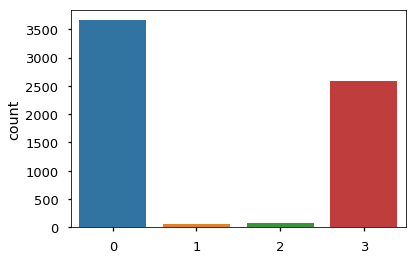

In [114]:
print (Counter(y_train_har))
sns.countplot(y_train_har)

Counter({0: 1493, 3: 525, 1: 71, 2: 36})


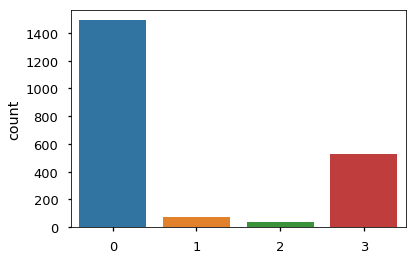

In [115]:
y_val_har=np.load("matrices/y_val_num_4.npy")
print (Counter(y_val_har))
sns.countplot(y_val_har)

# Otros settings

In [ ]:
#probar factor 5000 con 50 epochs y 0.4 dropout

In [30]:
V = 4
pesos = torch.from_numpy(class_weights).float()
print (pesos)
criterion = FocalLoss(weights=pesos)
model = make_model_concat(4, N=2,d_model=768, d_ff=128, h=4, dropout=0.4)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 5000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

hist_train_loss=[]
hist_train_acc=[]
hist_train_fma=[]
hist_val_loss=[]
hist_val_acc=[]
hist_val_fma=[]

for epoch in range(50):
    print ("")
    print (model_opt._rate)
    print ("")
    model.train()
    DATA=data_gen(35, 'Train', 4, new_matrix)
    loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
    hist_train_loss.append(loss_train)
    hist_train_acc.append(acc_train)
    hist_train_fma.append(fma_train)

    model.eval()
    loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
    print ("Validando Epoch",epoch)
    print ("loss_val:",loss_val)
    print ("Acc_val:",acc_val)
    print ("f_score_val:",fma_val)
    print ("f_score_val:",f_val_none)
    hist_val_loss.append(loss_val)
    hist_val_acc.append(acc_val)
    hist_val_fma.append(fma_val)

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
loss_val: tensor(2.2940)
Acc_val: tensor(0.6721, dtype=torch.float64)
f_score_val: tensor(0.3510, dtype=torch.float64)
f_score_val: tensor([0.7875, 0.0555, 0.0066, 0.5545], dtype=torch.float64)

1.867735928872173e-05

Validando Epoch 1
loss_val: tensor(2.2846)
Acc_val: tensor(0.6951, dtype=torch.float64)
f_score_val: tensor(0.3650, dtype=torch.float64)
f_score_val: tensor([0.8039, 0.0517, 0.0219, 0.5825], dtype=torch.float64)

3.735471857744346e-05

Validando Epoch 2
loss_val: tensor(2.2693)
Acc_val: tensor(0.7415, dtype=torch.float64)
f_score_val: tensor(0.3916, dtype=torch.float64)
f_score_val: tensor([0.8349, 0.0656, 0.0120, 0.6540], dtype=torch.float64)

5.603207786616519e-05

Validando Epoch 3
loss_val: tensor(2.2719)
Acc_val: tensor(0.7794, dtype=torch.float64)
f_score_val: tensor(0.4131, dtype=torch.float64)
f_score_val: tensor([0.8589, 0.0557, 0.0219, 0.7161], dtype=torch.float6

Validando Epoch 35
loss_val: tensor(2.0457)
Acc_val: tensor(0.8590, dtype=torch.float64)
f_score_val: tensor(0.4983, dtype=torch.float64)
f_score_val: tensor([0.9164, 0.1438, 0.0916, 0.8414], dtype=torch.float64)

0.00044457249976699993

Validando Epoch 36
loss_val: tensor(2.0408)
Acc_val: tensor(0.8600, dtype=torch.float64)
f_score_val: tensor(0.4970, dtype=torch.float64)
f_score_val: tensor([0.9187, 0.1293, 0.1005, 0.8394], dtype=torch.float64)

0.0004385236124730358

Validando Epoch 37
loss_val: tensor(2.0641)
Acc_val: tensor(0.8548, dtype=torch.float64)
f_score_val: tensor(0.4986, dtype=torch.float64)
f_score_val: tensor([0.9150, 0.1387, 0.1022, 0.8386], dtype=torch.float64)

0.00043271509624714986

Validando Epoch 38
loss_val: tensor(2.0651)
Acc_val: tensor(0.8604, dtype=torch.float64)
f_score_val: tensor(0.4977, dtype=torch.float64)
f_score_val: tensor([0.9186, 0.1139, 0.1169, 0.8411], dtype=torch.float64)

0.00042713144172121335

Validando Epoch 39
loss_val: tensor(2.0658)
Acc_v

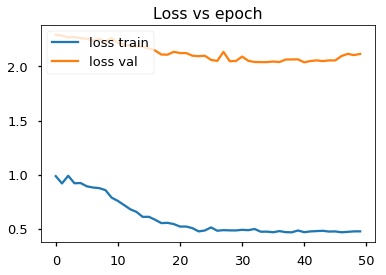

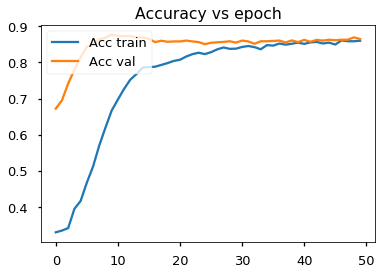

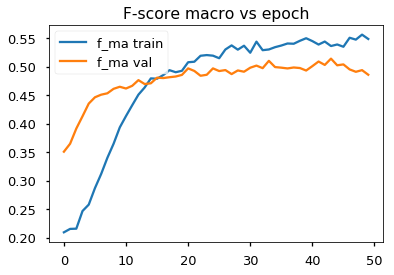

In [31]:
plt.plot(hist_train_loss, label='loss train')
plt.plot(hist_val_loss,label='loss val')
plt.legend(loc='upper left')
plt.title("Loss vs epoch")
plt.show()

plt.plot(hist_train_acc, label='Acc train')
plt.plot(hist_val_acc, label='Acc val')
plt.legend(loc='upper left')
plt.title("Accuracy vs epoch")
plt.show()

plt.plot(hist_train_fma, label='f_ma train')
plt.plot(hist_val_fma, label='f_ma val')
plt.legend(loc='upper left')
plt.title("F-score macro vs epoch")
plt.show()

In [32]:
model.eval()
print ("Validando")
loss_val, acc_val,fma_val, f_val_none, cm_val = run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
print ("Validando Epoch",epoch)
print ("loss_val:",loss_val)
print ("Acc_val:",acc_val)
print ("f_score_val:",fma_val)
print ("f_score_val:",f_val_none)

Validando
Validando Epoch 49
loss_val: tensor(2.0925)
Acc_val: tensor(0.8642, dtype=torch.float64)
f_score_val: tensor(0.4949, dtype=torch.float64)
f_score_val: tensor([0.9209, 0.1153, 0.1022, 0.8413], dtype=torch.float64)


Testing
SE TUVIERON QUE REPETIR 12 EJEMPLOS
(2135,)
Counter({0: 1570, 3: 363, 1: 131, 2: 71})


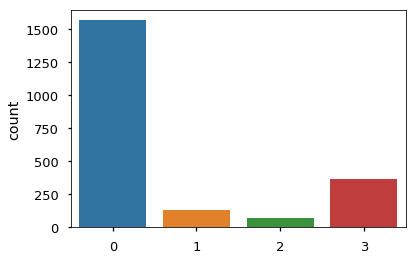

In [33]:
model.eval()
print ("Testing")
predicciones = run_epoch(data_gen(35, 'Test', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones=np.concatenate(predicciones, axis=-1)
print (predicciones.shape)
print (Counter(predicciones))
sns.countplot(predicciones)

In [34]:
predicciones[:4]

array([0, 0, 1, 0])

np.save("predicciones_5000_50_128_d4.npy",predicciones)

## Tha same, factor 2

In [36]:
V = 4
pesos = torch.from_numpy(class_weights).float()
print (pesos)
criterion = FocalLoss(weights=pesos)
model = make_model_concat(4, N=2,d_model=768, d_ff=128, h=4, dropout=0.4)
model_opt = NoamOpt(model.src_embed[0].d_model, 2, 5000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

hist_train_loss=[]
hist_train_acc=[]
hist_train_fma=[]
hist_val_loss=[]
hist_val_acc=[]
hist_val_fma=[]

for epoch in range(65):
    print ("")
    print (model_opt._rate)
    print ("")
    model.train()
    DATA=data_gen(35, 'Train', 4, new_matrix)
    loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
    hist_train_loss.append(loss_train)
    hist_train_acc.append(acc_train)
    hist_train_fma.append(fma_train)

    model.eval()
    loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
    print ("Validando Epoch",epoch)
    print ("loss_val:",loss_val)
    print ("Acc_val:",acc_val)
    print ("f_score_val:",fma_val)
    print ("f_score_val:",f_val_none)
    hist_val_loss.append(loss_val)
    hist_val_acc.append(acc_val)
    hist_val_fma.append(fma_val)

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
loss_val: tensor(2.2115)
Acc_val: tensor(0.3405, dtype=torch.float64)
f_score_val: tensor(0.1834, dtype=torch.float64)
f_score_val: tensor([0.5798, 0.0525, 0.0500, 0.0513], dtype=torch.float64)

3.735471857744346e-05

Validando Epoch 1
loss_val: tensor(2.1832)
Acc_val: tensor(0.3785, dtype=torch.float64)
f_score_val: tensor(0.1993, dtype=torch.float64)
f_score_val: tensor([0.6253, 0.0590, 0.0534, 0.0595], dtype=torch.float64)

7.470943715488692e-05

Validando Epoch 2
loss_val: tensor(2.1493)
Acc_val: tensor(0.4529, dtype=torch.float64)
f_score_val: tensor(0.2307, dtype=torch.float64)
f_score_val: tensor([0.7061, 0.0641, 0.0504, 0.1022], dtype=torch.float64)

0.00011206415573233038

Validando Epoch 3
loss_val: tensor(2.1520)
Acc_val: tensor(0.5719, dtype=torch.float64)
f_score_val: tensor(0.2921, dtype=torch.float64)
f_score_val: tensor([0.7898, 0.0616, 0.0487, 0.2682], dtype=torch.float

Validando Epoch 35
loss_val: tensor(2.0915)
Acc_val: tensor(0.8679, dtype=torch.float64)
f_score_val: tensor(0.4997, dtype=torch.float64)
f_score_val: tensor([0.9247, 0.1301, 0.1005, 0.8434], dtype=torch.float64)

0.0008891449995339999

Validando Epoch 36
loss_val: tensor(2.1020)
Acc_val: tensor(0.8674, dtype=torch.float64)
f_score_val: tensor(0.5004, dtype=torch.float64)
f_score_val: tensor([0.9239, 0.1290, 0.0995, 0.8494], dtype=torch.float64)

0.0008770472249460716

Validando Epoch 37
loss_val: tensor(2.0639)
Acc_val: tensor(0.8571, dtype=torch.float64)
f_score_val: tensor(0.4982, dtype=torch.float64)
f_score_val: tensor([0.9161, 0.1359, 0.0951, 0.8458], dtype=torch.float64)

0.0008654301924942997

Validando Epoch 38
loss_val: tensor(2.1036)
Acc_val: tensor(0.8660, dtype=torch.float64)
f_score_val: tensor(0.5006, dtype=torch.float64)
f_score_val: tensor([0.9227, 0.1270, 0.1087, 0.8438], dtype=torch.float64)

0.0008542628834424267

Validando Epoch 39
loss_val: tensor(2.0655)
Acc_val:

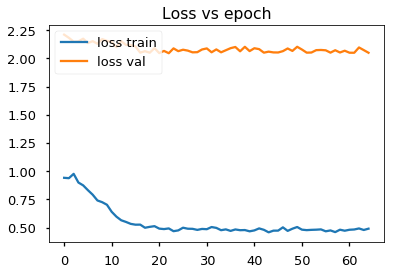

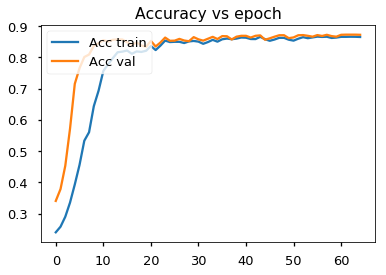

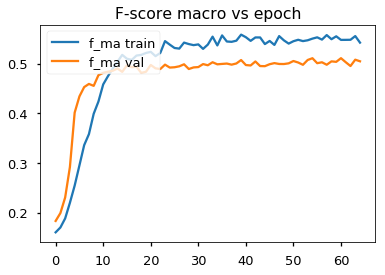

In [37]:
plt.plot(hist_train_loss, label='loss train')
plt.plot(hist_val_loss,label='loss val')
plt.legend(loc='upper left')
plt.title("Loss vs epoch")
plt.show()

plt.plot(hist_train_acc, label='Acc train')
plt.plot(hist_val_acc, label='Acc val')
plt.legend(loc='upper left')
plt.title("Accuracy vs epoch")
plt.show()

plt.plot(hist_train_fma, label='f_ma train')
plt.plot(hist_val_fma, label='f_ma val')
plt.legend(loc='upper left')
plt.title("F-score macro vs epoch")
plt.show()

Validando
Validando Epoch 64
loss_val: tensor(2.0815)
Acc_val: tensor(0.8731, dtype=torch.float64)
f_score_val: tensor(0.5086, dtype=torch.float64)
f_score_val: tensor([0.9275, 0.1397, 0.1262, 0.8409], dtype=torch.float64)
Testing
SE TUVIERON QUE REPETIR 12 EJEMPLOS
(2135,)
Counter({0: 1580, 3: 351, 1: 129, 2: 75})


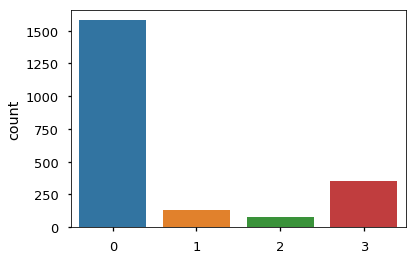

In [38]:
model.eval()
print ("Validando")
loss_val, acc_val,fma_val, f_val_none, cm_val = run_epoch(data_gen(35, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
print ("Validando Epoch",epoch)
print ("loss_val:",loss_val)
print ("Acc_val:",acc_val)
print ("f_score_val:",fma_val)
print ("f_score_val:",f_val_none)

model.eval()
print ("Testing")
predicciones = run_epoch(data_gen(35, 'Test', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
predicciones=np.concatenate(predicciones, axis=-1)
print (predicciones.shape)
print (Counter(predicciones))
sns.countplot(predicciones)

### Combinando parámetros



Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4581, dtype=torch.float64)
f_score_val: tensor([0.9180, 0.0075, 0.0806, 0.8264], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 1
f_score_val: tensor(0.4649, dtype=torch.float64)
f_score_val: tensor([0.9194, 0.0249, 0.0891, 0.8265], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 2
f_score_val: tensor(0.4883, dtype=torch.float64)
f_score_val: tensor([0.9265, 0.0896, 0.0945, 0.8425], dtype=torch.float64)

0.001473139127471974

Validando Epoch 3
f_score_val: tensor(0.4892, dtype=torch.float64)
f_score_val: tensor([0.9250, 0.1038, 0.0920, 0.8362], dtype=torch.float64)

0.0012757759076995718

Validando Epoch 4
f_score_val: tensor(0.4960, dtype=torch.float64)
f_score_val: tensor([0.9255, 0.1204, 0.1179, 0.8202], dtype=torch.float64)

0.001141088661469096

Validando E

Validando Epoch 49
f_score_val: tensor(0.4892, dtype=torch.float64)
f_score_val: tensor([0.9310, 0.1095, 0.0711, 0.8451], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4943, dtype=torch.float64)
f_score_val: tensor([0.9319, 0.1020, 0.1020, 0.8413], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4978, dtype=torch.float64)
f_score_val: tensor([0.9311, 0.1144, 0.1020, 0.8436], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4958, dtype=torch.float64)
f_score_val: tensor([0.9327, 0.1060, 0.0990, 0.8455], dtype=torch.float64)

0.0003504825963075276

Validando Epoch 53
f_score_val: tensor(0.4928, dtype=torch.float64)
f_score_val: tensor([0.9323, 0.1154, 0.0746, 0.8489], dtype=torch.float64)

0.0003472222222222222

Validando Epoch 54
f_score_val: tensor(0.4914, dtype=torch.float64)
f_score_val: tensor([0.9323, 0.0975, 0.0896, 0.8461], dtype=torch.float64)

0.000344051176601987

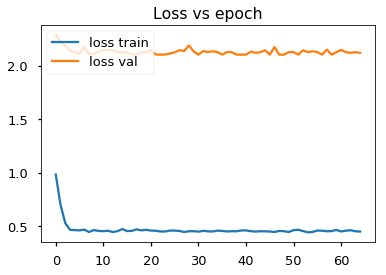

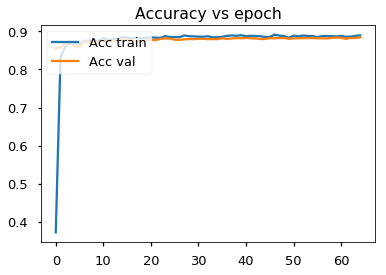

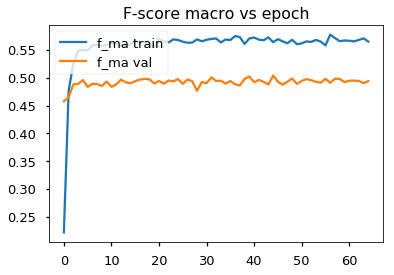

Validación final
Validando Epoch 64
loss_val: tensor(2.1581)
Acc_val: tensor(0.8820, dtype=torch.float64)
f_score_val: tensor(0.4893, dtype=torch.float64)
f_score_val: tensor([0.9314, 0.0968, 0.0826, 0.8465], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4634, dtype=torch.float64)
f_score_val: tensor([0.9284, 0.0891, 0.0000, 0.8363], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 1
f_score_val: tensor(0.4798, dtype=torch.float64)
f_score_val: tensor([0.9244, 0.0816, 0.0771, 0.8363], dtype=torch.float64)

0.0025819888974716113

Validando Epoch 2
f_score_val: tensor(0.4815, dtype=torch.float64)
f_score_val: tensor([0.9164, 0.1065, 0.0781, 0.8252], dtype=torch.float64)

0.002946278254943948

Validando Epoch 3
f_score_val: tensor(0.4906, dtype=torch.float64)
f_score_val: tensor([0.9101, 0.1480, 0.0766, 

Validando Epoch 47
f_score_val: tensor(0.4878, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.1159, 0.0622, 0.8419], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4894, dtype=torch.float64)
f_score_val: tensor([0.9303, 0.1075, 0.0721, 0.8478], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4942, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.1408, 0.0647, 0.8421], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4906, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.1085, 0.0746, 0.8479], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4878, dtype=torch.float64)
f_score_val: tensor([0.9316, 0.1114, 0.0647, 0.8434], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4895, dtype=torch.float64)
f_score_val: tensor([0.9286, 0.1328, 0.0522, 0.8441], dtype=torch.float64)

0.0007009651926150552


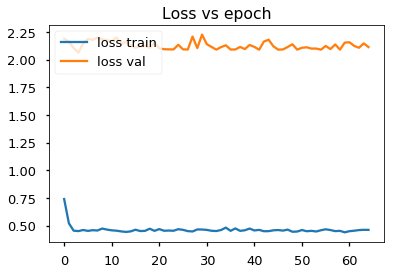

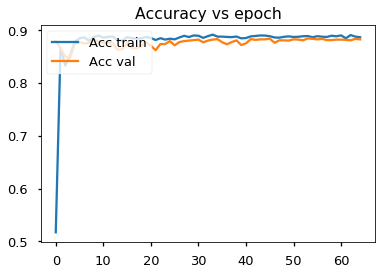

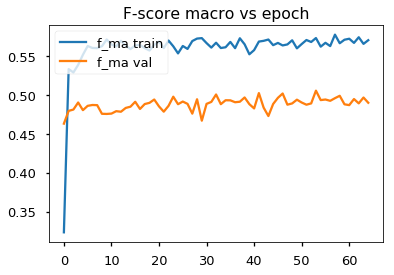

Validación final
Validando Epoch 64
loss_val: tensor(2.0990)
Acc_val: tensor(0.8834, dtype=torch.float64)
f_score_val: tensor(0.4994, dtype=torch.float64)
f_score_val: tensor([0.9320, 0.1353, 0.0796, 0.8507], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4707, dtype=torch.float64)
f_score_val: tensor([0.9089, 0.0985, 0.0348, 0.8404], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 1
f_score_val: tensor(0.4789, dtype=torch.float64)
f_score_val: tensor([0.8991, 0.1279, 0.0836, 0.8049], dtype=torch.float64)

0.003872983346207417

Validando Epoch 2
f_score_val: tensor(0.4813, dtype=torch.float64)
f_score_val: tensor([0.9082, 0.1115, 0.0672, 0.8385], dtype=torch.float64)

0.004419417382415922

Validando Epoch 3
f_score_val: tensor(0.4844, dtype=torch.float64)
f_score_val: tensor([0.9180, 0.1159, 0.0697, 0

Validando Epoch 48
f_score_val: tensor(0.4920, dtype=torch.float64)
f_score_val: tensor([0.9288, 0.1224, 0.0672, 0.8497], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4924, dtype=torch.float64)
f_score_val: tensor([0.9322, 0.1139, 0.0697, 0.8539], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.4976, dtype=torch.float64)
f_score_val: tensor([0.9292, 0.1209, 0.0871, 0.8531], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.5016, dtype=torch.float64)
f_score_val: tensor([0.9276, 0.1522, 0.0731, 0.8533], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.5013, dtype=torch.float64)
f_score_val: tensor([0.9297, 0.1413, 0.0821, 0.8520], dtype=torch.float64)

0.0010514477889225827

Validando Epoch 53
f_score_val: tensor(0.4954, dtype=torch.float64)
f_score_val: tensor([0.9295, 0.1114, 0.0841, 0.8565], dtype=torch.float64)

0.0010416666666666664


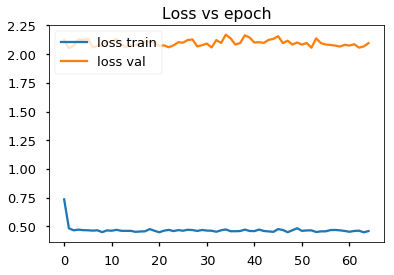

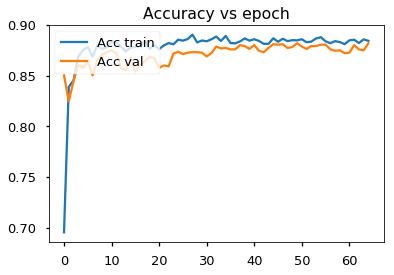

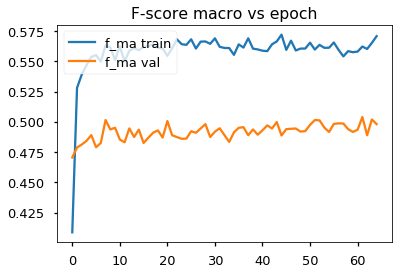

Validación final
Validando Epoch 64
loss_val: tensor(2.0894)
Acc_val: tensor(0.8815, dtype=torch.float64)
f_score_val: tensor(0.4981, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.1338, 0.0771, 0.8492], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4212, dtype=torch.float64)
f_score_val: tensor([0.8629, 0.0199, 0.0438, 0.7584], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 1
f_score_val: tensor(0.4794, dtype=torch.float64)
f_score_val: tensor([0.9294, 0.0821, 0.0856, 0.8208], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 2
f_score_val: tensor(0.4835, dtype=torch.float64)
f_score_val: tensor([0.9247, 0.0955, 0.0756, 0.8383], dtype=torch.float64)

0.001473139127471974

Validando Epoch 3
f_score_val: tensor(0.4816, dtype=torch.float64)
f_score_val: tensor([0.9242, 0.1139, 0.0632, 

Validando Epoch 47
f_score_val: tensor(0.4930, dtype=torch.float64)
f_score_val: tensor([0.9339, 0.0940, 0.0945, 0.8494], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4947, dtype=torch.float64)
f_score_val: tensor([0.9294, 0.1240, 0.0781, 0.8474], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.5009, dtype=torch.float64)
f_score_val: tensor([0.9345, 0.1279, 0.0920, 0.8490], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4922, dtype=torch.float64)
f_score_val: tensor([0.9346, 0.1070, 0.0806, 0.8465], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4902, dtype=torch.float64)
f_score_val: tensor([0.9334, 0.1055, 0.0746, 0.8472], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4935, dtype=torch.float64)
f_score_val: tensor([0.9327, 0.1020, 0.0896, 0.8497], dtype=torch.float64)

0.00035048259630752

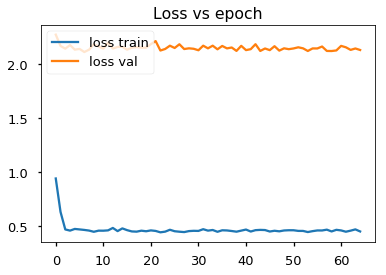

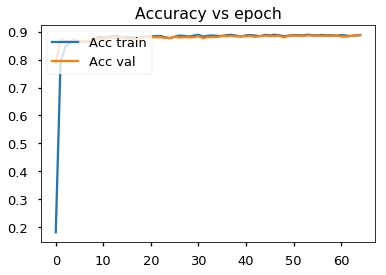

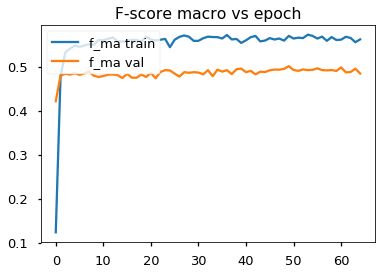

Validación final
Validando Epoch 64
loss_val: tensor(2.2021)
Acc_val: tensor(0.8862, dtype=torch.float64)
f_score_val: tensor(0.4894, dtype=torch.float64)
f_score_val: tensor([0.9337, 0.1090, 0.0572, 0.8577], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4659, dtype=torch.float64)
f_score_val: tensor([0.8957, 0.0995, 0.0774, 0.7909], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 1
f_score_val: tensor(0.4786, dtype=torch.float64)
f_score_val: tensor([0.9184, 0.0834, 0.0896, 0.8230], dtype=torch.float64)

0.0025819888974716113

Validando Epoch 2
f_score_val: tensor(0.4808, dtype=torch.float64)
f_score_val: tensor([0.9097, 0.1192, 0.0692, 0.8252], dtype=torch.float64)

0.002946278254943948

Validando Epoch 3
f_score_val: tensor(0.4828, dtype=torch.float64)
f_score_val: tensor([0.9084, 0.1131, 0.0757, 

Validando Epoch 47
f_score_val: tensor(0.4917, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.1284, 0.0716, 0.8370], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4937, dtype=torch.float64)
f_score_val: tensor([0.9272, 0.1158, 0.0846, 0.8473], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4985, dtype=torch.float64)
f_score_val: tensor([0.9277, 0.1502, 0.0746, 0.8414], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4889, dtype=torch.float64)
f_score_val: tensor([0.9245, 0.1364, 0.0657, 0.8291], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4937, dtype=torch.float64)
f_score_val: tensor([0.9244, 0.1349, 0.0871, 0.8286], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4910, dtype=torch.float64)
f_score_val: tensor([0.9249, 0.1189, 0.0896, 0.8306], dtype=torch.float64)

0.0007009651926150552


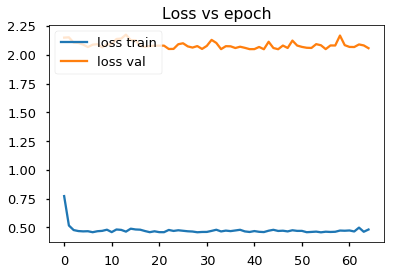

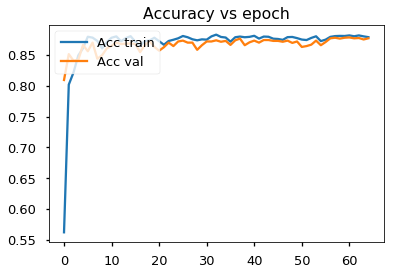

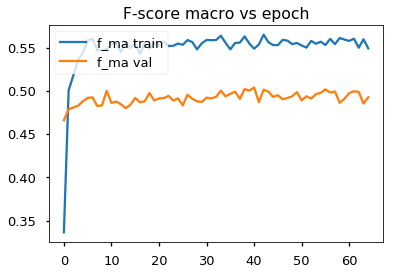

Validación final
Validando Epoch 64
loss_val: tensor(2.0743)
Acc_val: tensor(0.8750, dtype=torch.float64)
f_score_val: tensor(0.4985, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.1521, 0.0771, 0.8340], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4492, dtype=torch.float64)
f_score_val: tensor([0.9270, 0.0473, 0.0000, 0.8226], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 1
f_score_val: tensor(0.4815, dtype=torch.float64)
f_score_val: tensor([0.9142, 0.1077, 0.0920, 0.8119], dtype=torch.float64)

0.003872983346207417

Validando Epoch 2
f_score_val: tensor(0.4808, dtype=torch.float64)
f_score_val: tensor([0.9225, 0.1075, 0.0746, 0.8186], dtype=torch.float64)

0.004419417382415922

Validando Epoch 3
f_score_val: tensor(0.4807, dtype=torch.float64)
f_score_val: tensor([0.9252, 0.0980, 0.0846, 0

Validando Epoch 48
f_score_val: tensor(0.4863, dtype=torch.float64)
f_score_val: tensor([0.9302, 0.0726, 0.0955, 0.8469], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4850, dtype=torch.float64)
f_score_val: tensor([0.9291, 0.0945, 0.0746, 0.8416], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.4868, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.0891, 0.0821, 0.8466], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.4846, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.0806, 0.0846, 0.8426], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.4837, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.0826, 0.0796, 0.8418], dtype=torch.float64)

0.0010514477889225827

Validando Epoch 53
f_score_val: tensor(0.4870, dtype=torch.float64)
f_score_val: tensor([0.9322, 0.0756, 0.0995, 0.8406], dtype=torch.float64)

0.0010416666666666664


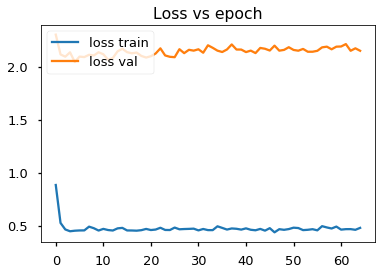

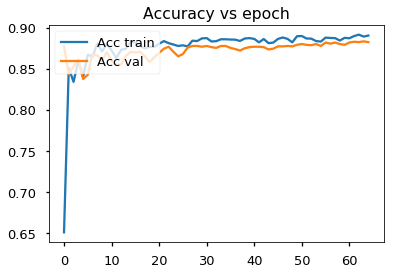

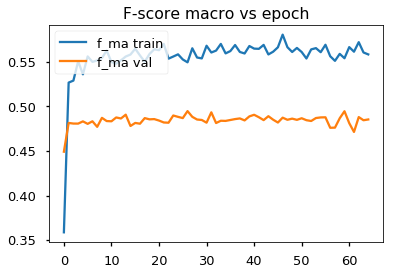

Validación final
Validando Epoch 64
loss_val: tensor(2.1980)
Acc_val: tensor(0.8806, dtype=torch.float64)
f_score_val: tensor(0.4845, dtype=torch.float64)
f_score_val: tensor([0.9298, 0.0990, 0.0846, 0.8247], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2068, dtype=torch.float64)
f_score_val: tensor([0.7487, 0.0373, 0.0000, 0.0413], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 1
f_score_val: tensor(0.2191, dtype=torch.float64)
f_score_val: tensor([0.7791, 0.0348, 0.0000, 0.0623], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 2
f_score_val: tensor(0.2882, dtype=torch.float64)
f_score_val: tensor([0.8275, 0.0316, 0.0149, 0.2787], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 3
f_score_val: tensor(0.4264, dtype=torch.float64)
f_score_val: tensor([0.9043, 0.0622, 0.042

Validando Epoch 47
f_score_val: tensor(0.4860, dtype=torch.float64)
f_score_val: tensor([0.9326, 0.0945, 0.0826, 0.8342], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4888, dtype=torch.float64)
f_score_val: tensor([0.9332, 0.0791, 0.1070, 0.8360], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.4835, dtype=torch.float64)
f_score_val: tensor([0.9325, 0.0796, 0.0746, 0.8473], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4881, dtype=torch.float64)
f_score_val: tensor([0.9340, 0.0905, 0.0821, 0.8456], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4797, dtype=torch.float64)
f_score_val: tensor([0.9297, 0.0806, 0.0751, 0.8333], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4947, dtype=torch.float64)
f_score_val: tensor([0.9327, 0.0905, 0.1104, 0.8450], dtype=torch.float64)

0.00035048259630752

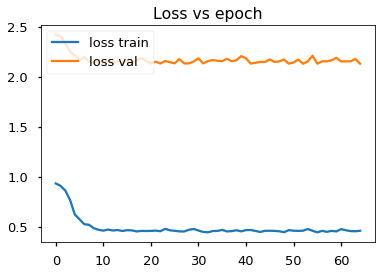

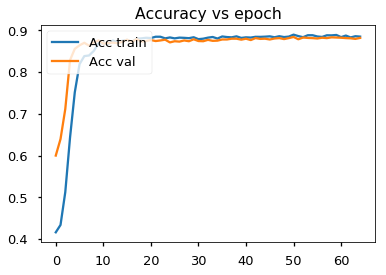

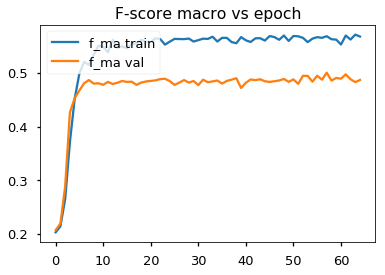

Validación final
Validando Epoch 64
loss_val: tensor(2.1769)
Acc_val: tensor(0.8815, dtype=torch.float64)
f_score_val: tensor(0.4863, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.0749, 0.0990, 0.8388], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2843, dtype=torch.float64)
f_score_val: tensor([0.6148, 0.0552, 0.0249, 0.4425], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 1
f_score_val: tensor(0.4090, dtype=torch.float64)
f_score_val: tensor([0.8826, 0.0532, 0.0174, 0.6827], dtype=torch.float64)

0.00017568209223157663

Validando Epoch 2
f_score_val: tensor(0.4498, dtype=torch.float64)
f_score_val: tensor([0.9208, 0.0749, 0.0333, 0.7701], dtype=torch.float64)

0.0002635231383473649

Validando Epoch 3
f_score_val: tensor(0.4689, dtype=torch.float64)
f_score_val: tensor([0.9236, 0.0995, 0.049

Validando Epoch 47
f_score_val: tensor(0.4966, dtype=torch.float64)
f_score_val: tensor([0.9305, 0.1090, 0.1005, 0.8465], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4943, dtype=torch.float64)
f_score_val: tensor([0.9318, 0.1020, 0.0920, 0.8514], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4894, dtype=torch.float64)
f_score_val: tensor([0.9335, 0.0756, 0.0995, 0.8488], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4946, dtype=torch.float64)
f_score_val: tensor([0.9338, 0.1179, 0.0796, 0.8471], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4980, dtype=torch.float64)
f_score_val: tensor([0.9347, 0.1179, 0.0930, 0.8462], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4930, dtype=torch.float64)
f_score_val: tensor([0.9326, 0.1020, 0.0920, 0.8454], dtype=torch.float64)

0.0007009651926150552


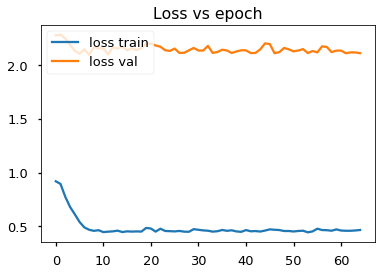

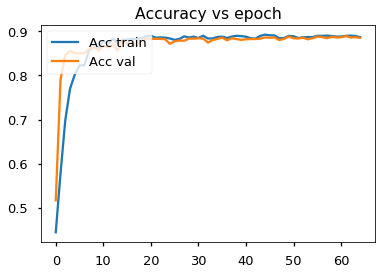

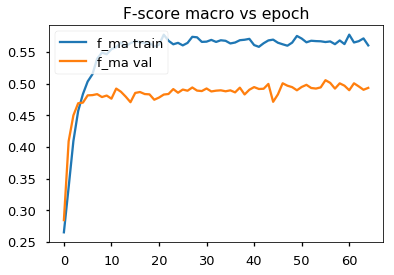

Validación final
Validando Epoch 64
loss_val: tensor(2.1288)
Acc_val: tensor(0.8871, dtype=torch.float64)
f_score_val: tensor(0.4983, dtype=torch.float64)
f_score_val: tensor([0.9354, 0.1090, 0.0995, 0.8494], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0784, dtype=torch.float64)
f_score_val: tensor([0.1161, 0.0268, 0.0332, 0.1375], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 1
f_score_val: tensor(0.1643, dtype=torch.float64)
f_score_val: tensor([0.1796, 0.0525, 0.0356, 0.3896], dtype=torch.float64)

0.0002635231383473649

Validando Epoch 2
f_score_val: tensor(0.2315, dtype=torch.float64)
f_score_val: tensor([0.1541, 0.0688, 0.0484, 0.6549], dtype=torch.float64)

0.00039528470752104737

Validando Epoch 3
f_score_val: tensor(0.3688, dtype=torch.float64)
f_score_val: tensor([0.5747, 0.0676, 0.05

Validando Epoch 47
f_score_val: tensor(0.4849, dtype=torch.float64)
f_score_val: tensor([0.9298, 0.1035, 0.0547, 0.8516], dtype=torch.float64)

0.0011048543456039805

Validando Epoch 48
f_score_val: tensor(0.4880, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.1353, 0.0348, 0.8512], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4833, dtype=torch.float64)
f_score_val: tensor([0.9309, 0.1165, 0.0408, 0.8449], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.4764, dtype=torch.float64)
f_score_val: tensor([0.9320, 0.0886, 0.0348, 0.8504], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.4794, dtype=torch.float64)
f_score_val: tensor([0.9326, 0.0990, 0.0547, 0.8314], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.4840, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.1048, 0.0522, 0.8486], dtype=torch.float64)

0.0010514477889225827


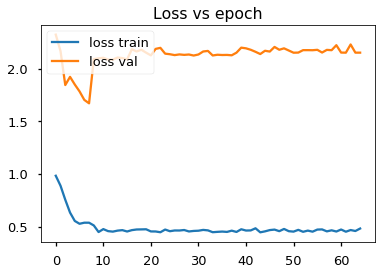

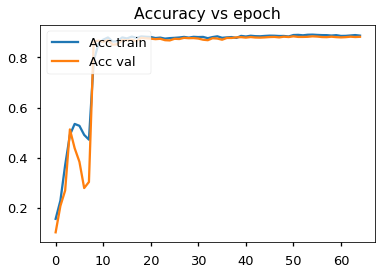

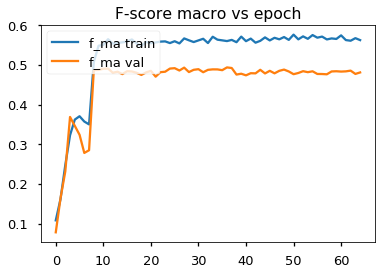

Validación final
Validando Epoch 64
loss_val: tensor(2.1996)
Acc_val: tensor(0.8801, dtype=torch.float64)
f_score_val: tensor(0.4815, dtype=torch.float64)
f_score_val: tensor([0.9286, 0.0905, 0.0597, 0.8470], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2775, dtype=torch.float64)
f_score_val: tensor([0.8184, 0.0060, 0.0546, 0.2311], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 1
f_score_val: tensor(0.3150, dtype=torch.float64)
f_score_val: tensor([0.8493, 0.0075, 0.0586, 0.3449], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 2
f_score_val: tensor(0.3983, dtype=torch.float64)
f_score_val: tensor([0.8825, 0.0284, 0.0753, 0.6071], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 3
f_score_val: tensor(0.4462, dtype=torch.float64)
f_score_val: tensor([0.9137, 0.0075, 0.079

Validando Epoch 47
f_score_val: tensor(0.4934, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.0853, 0.1189, 0.8389], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4856, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.0751, 0.1000, 0.8368], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.4735, dtype=torch.float64)
f_score_val: tensor([0.9315, 0.0779, 0.0498, 0.8347], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4860, dtype=torch.float64)
f_score_val: tensor([0.9309, 0.0766, 0.0945, 0.8422], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.5007, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.0940, 0.1318, 0.8461], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4926, dtype=torch.float64)
f_score_val: tensor([0.9303, 0.0920, 0.1104, 0.8375], dtype=torch.float64)

0.00035048259630752

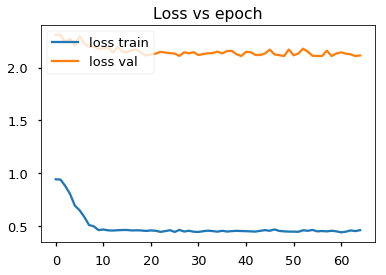

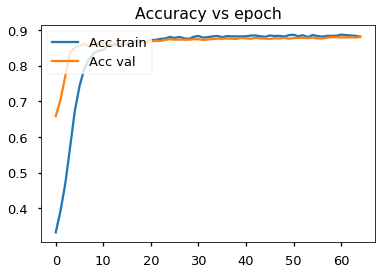

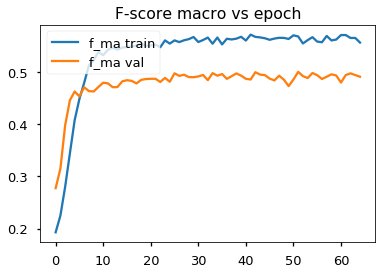

Validación final
Validando Epoch 64
loss_val: tensor(2.1066)
Acc_val: tensor(0.8820, dtype=torch.float64)
f_score_val: tensor(0.4948, dtype=torch.float64)
f_score_val: tensor([0.9328, 0.1015, 0.1015, 0.8436], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2877, dtype=torch.float64)
f_score_val: tensor([0.6650, 0.0737, 0.0000, 0.4123], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 1
f_score_val: tensor(0.3854, dtype=torch.float64)
f_score_val: tensor([0.8026, 0.0787, 0.0000, 0.6604], dtype=torch.float64)

0.00017568209223157663

Validando Epoch 2
f_score_val: tensor(0.4519, dtype=torch.float64)
f_score_val: tensor([0.8919, 0.0824, 0.0448, 0.7885], dtype=torch.float64)

0.0002635231383473649

Validando Epoch 3
f_score_val: tensor(0.4760, dtype=torch.float64)
f_score_val: tensor([0.9024, 0.1171, 0.064

Validando Epoch 47
f_score_val: tensor(0.4914, dtype=torch.float64)
f_score_val: tensor([0.9300, 0.1244, 0.0660, 0.8454], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4845, dtype=torch.float64)
f_score_val: tensor([0.9294, 0.1075, 0.0632, 0.8378], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4824, dtype=torch.float64)
f_score_val: tensor([0.9329, 0.0785, 0.0771, 0.8412], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4875, dtype=torch.float64)
f_score_val: tensor([0.9285, 0.1070, 0.0771, 0.8376], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4966, dtype=torch.float64)
f_score_val: tensor([0.9315, 0.1129, 0.1045, 0.8377], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4964, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.1115, 0.1020, 0.8414], dtype=torch.float64)

0.0007009651926150552


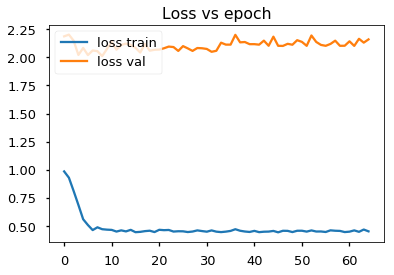

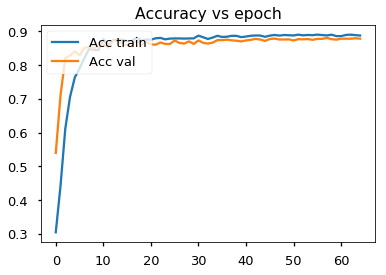

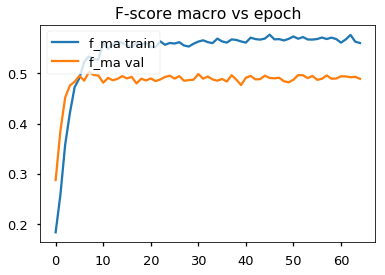

Validación final
Validando Epoch 64
loss_val: tensor(2.1011)
Acc_val: tensor(0.8797, dtype=torch.float64)
f_score_val: tensor(0.4901, dtype=torch.float64)
f_score_val: tensor([0.9336, 0.1058, 0.0841, 0.8368], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.3443, dtype=torch.float64)
f_score_val: tensor([0.8387, 0.0323, 0.0000, 0.5062], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 1
f_score_val: tensor(0.4394, dtype=torch.float64)
f_score_val: tensor([0.9167, 0.0378, 0.0000, 0.8031], dtype=torch.float64)

0.0002635231383473649

Validando Epoch 2
f_score_val: tensor(0.4702, dtype=torch.float64)
f_score_val: tensor([0.9328, 0.1005, 0.0075, 0.8402], dtype=torch.float64)

0.00039528470752104737

Validando Epoch 3
f_score_val: tensor(0.4774, dtype=torch.float64)
f_score_val: tensor([0.9306, 0.0930, 0.05

Validando Epoch 47
f_score_val: tensor(0.4881, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.1080, 0.0721, 0.8400], dtype=torch.float64)

0.0011048543456039805

Validando Epoch 48
f_score_val: tensor(0.4882, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.1244, 0.0560, 0.8418], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4810, dtype=torch.float64)
f_score_val: tensor([0.9250, 0.1040, 0.0557, 0.8393], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.4835, dtype=torch.float64)
f_score_val: tensor([0.9252, 0.1112, 0.0672, 0.8306], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.4845, dtype=torch.float64)
f_score_val: tensor([0.9291, 0.1189, 0.0572, 0.8330], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.4880, dtype=torch.float64)
f_score_val: tensor([0.9312, 0.1110, 0.0672, 0.8426], dtype=torch.float64)

0.0010514477889225827


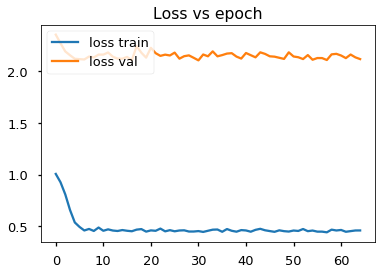

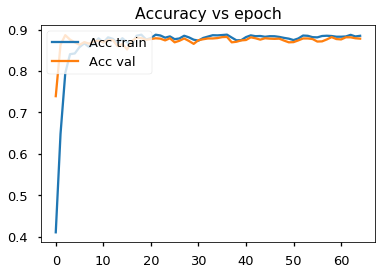

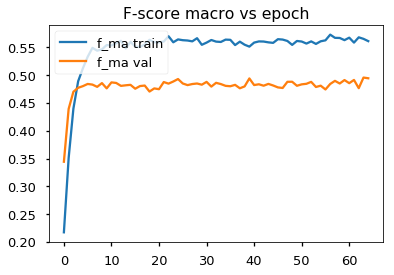

Validación final
Validando Epoch 64
loss_val: tensor(2.1368)
Acc_val: tensor(0.8773, dtype=torch.float64)
f_score_val: tensor(0.4789, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.0920, 0.0542, 0.8396], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2452, dtype=torch.float64)
f_score_val: tensor([0.8908, 0.0389, 0.0318, 0.0194], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 1
f_score_val: tensor(0.2496, dtype=torch.float64)
f_score_val: tensor([0.8912, 0.0432, 0.0449, 0.0190], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 2
f_score_val: tensor(0.2550, dtype=torch.float64)
f_score_val: tensor([0.8971, 0.0578, 0.0434, 0.0218], dtype=torch.float64)

6.123724356957945e-05

Validando Epoch 3
f_score_val: tensor(0.2661, dtype=torch.float64)
f_score_val: tensor([0.9022, 0.0620, 0.045

Validando Epoch 47
f_score_val: tensor(0.4778, dtype=torch.float64)
f_score_val: tensor([0.9309, 0.0781, 0.0547, 0.8477], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4800, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.0831, 0.0597, 0.8473], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.4819, dtype=torch.float64)
f_score_val: tensor([0.9296, 0.0973, 0.0517, 0.8489], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4781, dtype=torch.float64)
f_score_val: tensor([0.9296, 0.0817, 0.0517, 0.8495], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4856, dtype=torch.float64)
f_score_val: tensor([0.9288, 0.1045, 0.0697, 0.8397], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4839, dtype=torch.float64)
f_score_val: tensor([0.9305, 0.1104, 0.0547, 0.8397], dtype=torch.float64)

0.00035048259630752

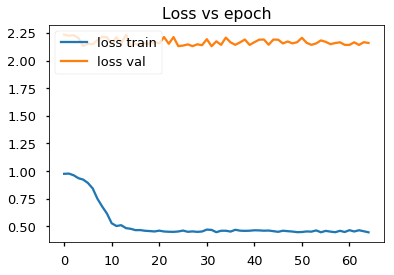

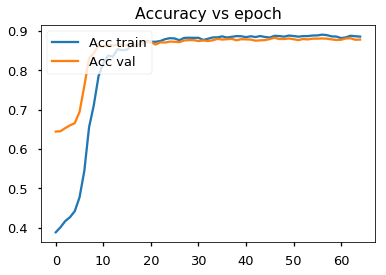

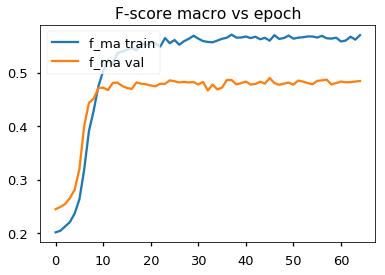

Validación final
Validando Epoch 64
loss_val: tensor(2.1659)
Acc_val: tensor(0.8783, dtype=torch.float64)
f_score_val: tensor(0.4844, dtype=torch.float64)
f_score_val: tensor([0.9302, 0.1119, 0.0557, 0.8400], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1699, dtype=torch.float64)
f_score_val: tensor([0.6238, 0.0199, 0.0000, 0.0360], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 1
f_score_val: tensor(0.1937, dtype=torch.float64)
f_score_val: tensor([0.7173, 0.0170, 0.0000, 0.0405], dtype=torch.float64)

8.164965809277258e-05

Validando Epoch 2
f_score_val: tensor(0.2613, dtype=torch.float64)
f_score_val: tensor([0.8341, 0.0256, 0.0000, 0.1854], dtype=torch.float64)

0.0001224744871391589

Validando Epoch 3
f_score_val: tensor(0.3893, dtype=torch.float64)
f_score_val: tensor([0.8925, 0.0100, 0.0000

Validando Epoch 47
f_score_val: tensor(0.4913, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.1498, 0.0522, 0.8338], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4897, dtype=torch.float64)
f_score_val: tensor([0.9297, 0.1398, 0.0458, 0.8435], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4833, dtype=torch.float64)
f_score_val: tensor([0.9254, 0.1308, 0.0468, 0.8304], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4883, dtype=torch.float64)
f_score_val: tensor([0.9310, 0.1627, 0.0274, 0.8322], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4893, dtype=torch.float64)
f_score_val: tensor([0.9306, 0.1264, 0.0622, 0.8382], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4932, dtype=torch.float64)
f_score_val: tensor([0.9261, 0.1527, 0.0532, 0.8408], dtype=torch.float64)

0.0007009651926150552


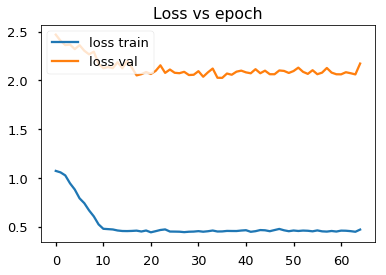

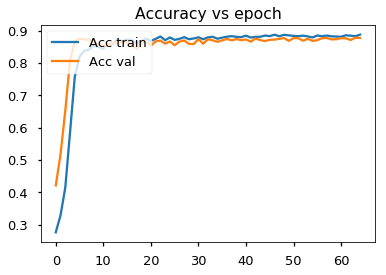

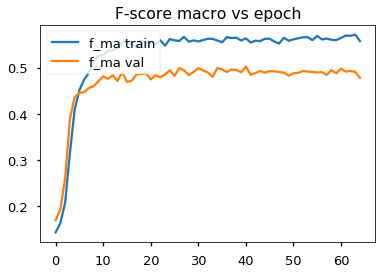

Validación final
Validando Epoch 64
loss_val: tensor(2.1738)
Acc_val: tensor(0.8764, dtype=torch.float64)
f_score_val: tensor(0.4787, dtype=torch.float64)
f_score_val: tensor([0.9306, 0.0980, 0.0507, 0.8353], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 32  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1630, dtype=torch.float64)
f_score_val: tensor([0.1655, 0.0555, 0.0226, 0.4086], dtype=torch.float64)

6.123724356957943e-05

Validando Epoch 1
f_score_val: tensor(0.2360, dtype=torch.float64)
f_score_val: tensor([0.2961, 0.0461, 0.0268, 0.5751], dtype=torch.float64)

0.00012247448713915887

Validando Epoch 2
f_score_val: tensor(0.3274, dtype=torch.float64)
f_score_val: tensor([0.5119, 0.0790, 0.0303, 0.6883], dtype=torch.float64)

0.00018371173070873834

Validando Epoch 3
f_score_val: tensor(0.4214, dtype=torch.float64)
f_score_val: tensor([0.7819, 0.0756, 0.05

Validando Epoch 47
f_score_val: tensor(0.4977, dtype=torch.float64)
f_score_val: tensor([0.9297, 0.1353, 0.0826, 0.8431], dtype=torch.float64)

0.0011048543456039805

Validando Epoch 48
f_score_val: tensor(0.5079, dtype=torch.float64)
f_score_val: tensor([0.9305, 0.1597, 0.0970, 0.8443], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4957, dtype=torch.float64)
f_score_val: tensor([0.9297, 0.1023, 0.0965, 0.8542], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.5118, dtype=torch.float64)
f_score_val: tensor([0.9303, 0.1478, 0.1179, 0.8513], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.4860, dtype=torch.float64)
f_score_val: tensor([0.9282, 0.0877, 0.0970, 0.8311], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.4889, dtype=torch.float64)
f_score_val: tensor([0.9301, 0.1087, 0.0721, 0.8447], dtype=torch.float64)

0.0010514477889225827


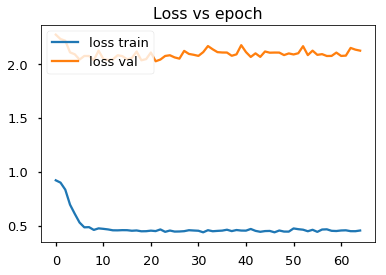

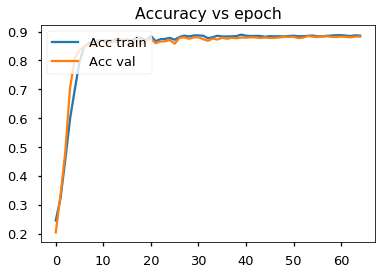

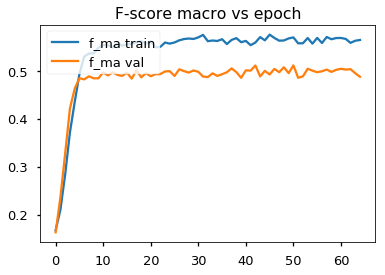

Validación final
Validando Epoch 64
loss_val: tensor(2.1086)
Acc_val: tensor(0.8825, dtype=torch.float64)
f_score_val: tensor(0.4885, dtype=torch.float64)
f_score_val: tensor([0.9330, 0.0955, 0.0796, 0.8457], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0572, dtype=torch.float64)
f_score_val: tensor([0.0387, 0.0215, 0.0119, 0.1567], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 1
f_score_val: tensor(0.0669, dtype=torch.float64)
f_score_val: tensor([0.0436, 0.0219, 0.0199, 0.1822], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 2
f_score_val: tensor(0.0787, dtype=torch.float64)
f_score_val: tensor([0.0598, 0.0254, 0.0149, 0.2146], dtype=torch.float64)

6.123724356957945e-05

Validando Epoch 3
f_score_val: tensor(0.1052, dtype=torch.float64)
f_score_val: tensor([0.1169, 0.0092, 0.017

Validando Epoch 47
f_score_val: tensor(0.4942, dtype=torch.float64)
f_score_val: tensor([0.9321, 0.1129, 0.1055, 0.8262], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4976, dtype=torch.float64)
f_score_val: tensor([0.9325, 0.1180, 0.0995, 0.8404], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.4884, dtype=torch.float64)
f_score_val: tensor([0.9318, 0.1134, 0.0821, 0.8263], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4924, dtype=torch.float64)
f_score_val: tensor([0.9321, 0.1095, 0.0905, 0.8373], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4959, dtype=torch.float64)
f_score_val: tensor([0.9338, 0.1095, 0.1070, 0.8334], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4887, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.0882, 0.1020, 0.8323], dtype=torch.float64)

0.00035048259630752

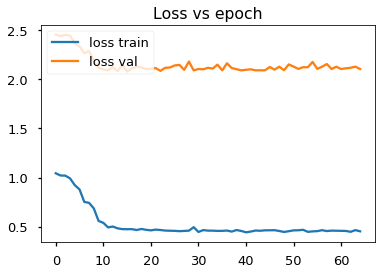

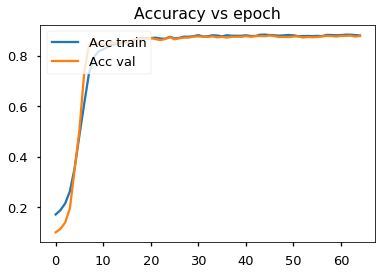

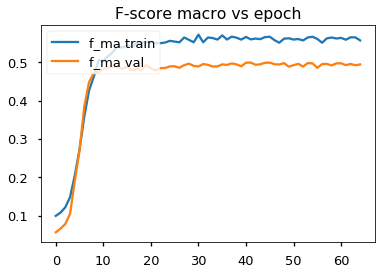

Validación final
Validando Epoch 64
loss_val: tensor(2.1456)
Acc_val: tensor(0.8778, dtype=torch.float64)
f_score_val: tensor(0.4911, dtype=torch.float64)
f_score_val: tensor([0.9337, 0.0950, 0.0980, 0.8375], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1565, dtype=torch.float64)
f_score_val: tensor([0.4164, 0.0670, 0.0180, 0.1246], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 1
f_score_val: tensor(0.2530, dtype=torch.float64)
f_score_val: tensor([0.4588, 0.0700, 0.0199, 0.4631], dtype=torch.float64)

8.164965809277258e-05

Validando Epoch 2
f_score_val: tensor(0.3444, dtype=torch.float64)
f_score_val: tensor([0.6014, 0.0774, 0.0207, 0.6779], dtype=torch.float64)

0.0001224744871391589

Validando Epoch 3
f_score_val: tensor(0.3495, dtype=torch.float64)
f_score_val: tensor([0.5385, 0.0752, 0.0299

Validando Epoch 47
f_score_val: tensor(0.5022, dtype=torch.float64)
f_score_val: tensor([0.9187, 0.1441, 0.1070, 0.8390], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4860, dtype=torch.float64)
f_score_val: tensor([0.9256, 0.0844, 0.0896, 0.8446], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4937, dtype=torch.float64)
f_score_val: tensor([0.9284, 0.0970, 0.1070, 0.8425], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4837, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.0821, 0.0746, 0.8482], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4838, dtype=torch.float64)
f_score_val: tensor([0.9259, 0.0806, 0.0930, 0.8356], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4845, dtype=torch.float64)
f_score_val: tensor([0.9261, 0.0849, 0.0905, 0.8365], dtype=torch.float64)

0.0007009651926150552


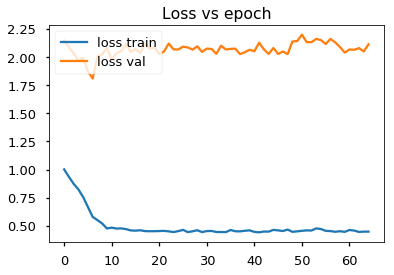

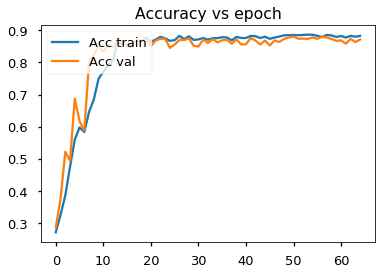

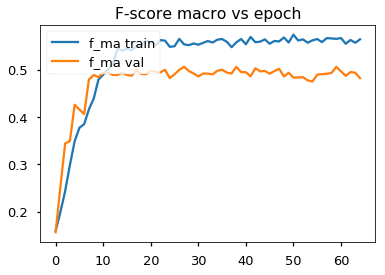

Validación final
Validando Epoch 64
loss_val: tensor(2.1128)
Acc_val: tensor(0.8713, dtype=torch.float64)
f_score_val: tensor(0.4854, dtype=torch.float64)
f_score_val: tensor([0.9234, 0.1154, 0.0672, 0.8357], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 32  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0586, dtype=torch.float64)
f_score_val: tensor([0.0342, 0.0377, 0.0392, 0.1233], dtype=torch.float64)

6.123724356957943e-05

Validando Epoch 1
f_score_val: tensor(0.0954, dtype=torch.float64)
f_score_val: tensor([0.0302, 0.0856, 0.0498, 0.2160], dtype=torch.float64)

0.00012247448713915887

Validando Epoch 2
f_score_val: tensor(0.1210, dtype=torch.float64)
f_score_val: tensor([0.0129, 0.0901, 0.0470, 0.3341], dtype=torch.float64)

0.00018371173070873834

Validando Epoch 3
f_score_val: tensor(0.1261, dtype=torch.float64)
f_score_val: tensor([0.0041, 0.0802, 0.04

Validando Epoch 47
f_score_val: tensor(0.4807, dtype=torch.float64)
f_score_val: tensor([0.9292, 0.0950, 0.0622, 0.8364], dtype=torch.float64)

0.0011048543456039805

Validando Epoch 48
f_score_val: tensor(0.4800, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.0791, 0.0667, 0.8429], dtype=torch.float64)

0.001093522206599633

Validando Epoch 49
f_score_val: tensor(0.4868, dtype=torch.float64)
f_score_val: tensor([0.9306, 0.0881, 0.0821, 0.8464], dtype=torch.float64)

0.0010825317547305483

Validando Epoch 50
f_score_val: tensor(0.4858, dtype=torch.float64)
f_score_val: tensor([0.9287, 0.0925, 0.0856, 0.8365], dtype=torch.float64)

0.0010718661571406801

Validando Epoch 51
f_score_val: tensor(0.4890, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.0906, 0.0980, 0.8381], dtype=torch.float64)

0.0010615097195105585

Validando Epoch 52
f_score_val: tensor(0.4773, dtype=torch.float64)
f_score_val: tensor([0.9296, 0.0751, 0.0607, 0.8438], dtype=torch.float64)

0.0010514477889225827


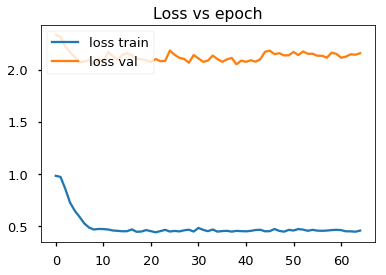

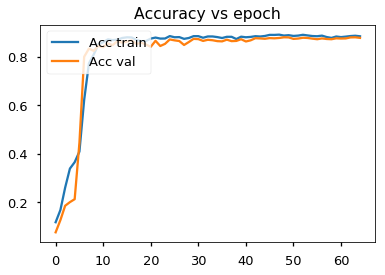

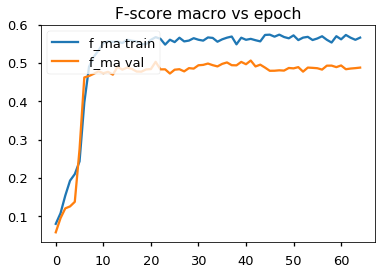

Validación final
Validando Epoch 64
loss_val: tensor(2.1470)
Acc_val: tensor(0.8778, dtype=torch.float64)
f_score_val: tensor(0.4866, dtype=torch.float64)
f_score_val: tensor([0.9298, 0.0980, 0.0796, 0.8388], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1729, dtype=torch.float64)
f_score_val: tensor([0.1847, 0.0501, 0.0815, 0.3755], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 1
f_score_val: tensor(0.2837, dtype=torch.float64)
f_score_val: tensor([0.3542, 0.0644, 0.0927, 0.6233], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 2
f_score_val: tensor(0.3477, dtype=torch.float64)
f_score_val: tensor([0.3861, 0.0685, 0.1627, 0.7736], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 3
f_score_val: tensor(0.4388, dtype=torch.float64)
f_score_val: tensor([0.7761, 0.0793, 0.1310,

Validando Epoch 47
f_score_val: tensor(0.5200, dtype=torch.float64)
f_score_val: tensor([0.8828, 0.1950, 0.1539, 0.8482], dtype=torch.float64)

0.0005208333333333333

Validando Epoch 48
f_score_val: tensor(0.5143, dtype=torch.float64)
f_score_val: tensor([0.8895, 0.1871, 0.1329, 0.8476], dtype=torch.float64)

0.0005154913117764515

Validando Epoch 49
f_score_val: tensor(0.4964, dtype=torch.float64)
f_score_val: tensor([0.9051, 0.1365, 0.1069, 0.8372], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5228, dtype=torch.float64)
f_score_val: tensor([0.8936, 0.1794, 0.1756, 0.8426], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.5160, dtype=torch.float64)
f_score_val: tensor([0.9003, 0.1855, 0.1300, 0.8483], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.5100, dtype=torch.float64)
f_score_val: tensor([0.8746, 0.1744, 0.1398, 0.8514], dtype=torch.float64)

0.0004956572410738401


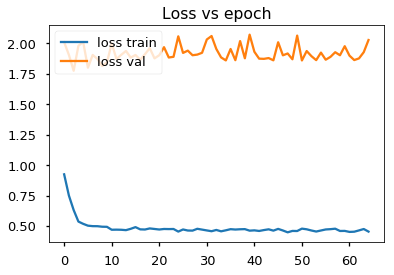

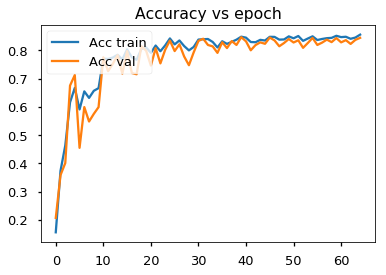

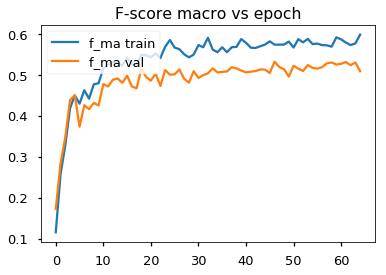

Validación final
Validando Epoch 64
loss_val: tensor(1.9486)
Acc_val: tensor(0.8460, dtype=torch.float64)
f_score_val: tensor(0.5300, dtype=torch.float64)
f_score_val: tensor([0.9088, 0.1969, 0.1662, 0.8478], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1235, dtype=torch.float64)
f_score_val: tensor([0.0037, 0.1084, 0.0000, 0.3817], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 1
f_score_val: tensor(0.4910, dtype=torch.float64)
f_score_val: tensor([0.9155, 0.1199, 0.1029, 0.8256], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 2
f_score_val: tensor(0.4862, dtype=torch.float64)
f_score_val: tensor([0.9118, 0.1338, 0.0834, 0.8157], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 3
f_score_val: tensor(0.4926, dtype=torch.float64)
f_score_val: tensor([0.9103, 0.1566, 0.1071,

Validando Epoch 47
f_score_val: tensor(0.5291, dtype=torch.float64)
f_score_val: tensor([0.9311, 0.1723, 0.1697, 0.8432], dtype=torch.float64)

0.0010416666666666667

Validando Epoch 48
f_score_val: tensor(0.5151, dtype=torch.float64)
f_score_val: tensor([0.9284, 0.1217, 0.1637, 0.8465], dtype=torch.float64)

0.001030982623552903

Validando Epoch 49
f_score_val: tensor(0.5245, dtype=torch.float64)
f_score_val: tensor([0.9315, 0.1704, 0.1510, 0.8451], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5166, dtype=torch.float64)
f_score_val: tensor([0.9330, 0.1716, 0.1152, 0.8468], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5305, dtype=torch.float64)
f_score_val: tensor([0.9287, 0.1595, 0.1863, 0.8474], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5356, dtype=torch.float64)
f_score_val: tensor([0.9292, 0.1836, 0.1833, 0.8464], dtype=torch.float64)

0.0009913144821476802



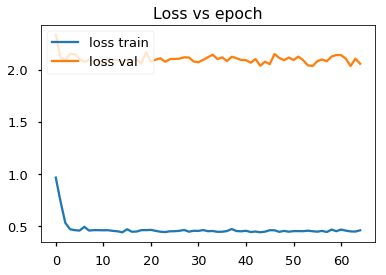

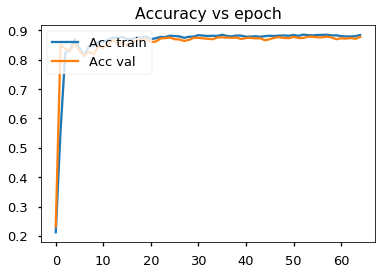

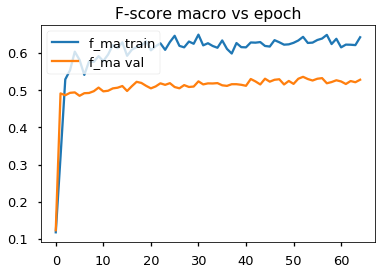

Validación final
Validando Epoch 64
loss_val: tensor(2.0586)
Acc_val: tensor(0.8778, dtype=torch.float64)
f_score_val: tensor(0.5219, dtype=torch.float64)
f_score_val: tensor([0.9326, 0.1598, 0.1480, 0.8472], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4743, dtype=torch.float64)
f_score_val: tensor([0.9314, 0.0794, 0.0490, 0.8374], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 1
f_score_val: tensor(0.4845, dtype=torch.float64)
f_score_val: tensor([0.9278, 0.0835, 0.1069, 0.8199], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 2
f_score_val: tensor(0.4863, dtype=torch.float64)
f_score_val: tensor([0.9186, 0.1030, 0.0923, 0.8312], dtype=torch.float64)

0.0029047375096555627

Validando Epoch 3
f_score_val: tensor(0.4941, dtype=torch.float64)
f_score_val: tensor([0.9211, 0.1277, 0.0976,

Validando Epoch 47
f_score_val: tensor(0.5104, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.1371, 0.1216, 0.8523], dtype=torch.float64)

0.0015625

Validando Epoch 48
f_score_val: tensor(0.4964, dtype=torch.float64)
f_score_val: tensor([0.9292, 0.1167, 0.0882, 0.8515], dtype=torch.float64)

0.0015464739353293546

Validando Epoch 49
f_score_val: tensor(0.4998, dtype=torch.float64)
f_score_val: tensor([0.9279, 0.1163, 0.1137, 0.8414], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.5041, dtype=torch.float64)
f_score_val: tensor([0.9274, 0.1364, 0.1069, 0.8455], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.5135, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.1417, 0.1363, 0.8468], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.4943, dtype=torch.float64)
f_score_val: tensor([0.9316, 0.1182, 0.0824, 0.8452], dtype=torch.float64)

0.0014869717232215201

Validando 

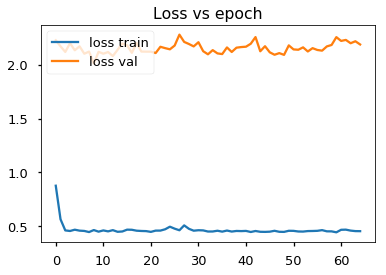

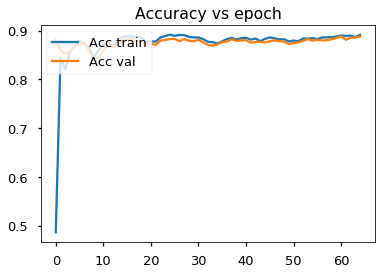

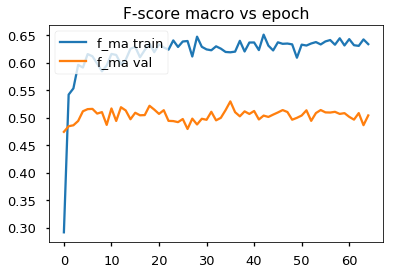

Validación final
Validando Epoch 64
loss_val: tensor(2.2583)
Acc_val: tensor(0.8874, dtype=torch.float64)
f_score_val: tensor(0.4874, dtype=torch.float64)
f_score_val: tensor([0.9350, 0.0951, 0.0657, 0.8538], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2472, dtype=torch.float64)
f_score_val: tensor([0.7721, 0.0403, 0.0457, 0.1307], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 1
f_score_val: tensor(0.4634, dtype=torch.float64)
f_score_val: tensor([0.9215, 0.0343, 0.1070, 0.7908], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 2
f_score_val: tensor(0.4990, dtype=torch.float64)
f_score_val: tensor([0.9262, 0.1099, 0.1150, 0.8449], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 3
f_score_val: tensor(0.4995, dtype=torch.float64)
f_score_val: tensor([0.9282, 0.0727, 0.1510,

Validando Epoch 47
f_score_val: tensor(0.5401, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.2178, 0.1539, 0.8577], dtype=torch.float64)

0.0005208333333333333

Validando Epoch 48
f_score_val: tensor(0.5269, dtype=torch.float64)
f_score_val: tensor([0.9282, 0.1937, 0.1260, 0.8598], dtype=torch.float64)

0.0005154913117764515

Validando Epoch 49
f_score_val: tensor(0.5376, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.2158, 0.1520, 0.8519], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5383, dtype=torch.float64)
f_score_val: tensor([0.9281, 0.1869, 0.1784, 0.8597], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.5374, dtype=torch.float64)
f_score_val: tensor([0.9282, 0.1859, 0.1765, 0.8590], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.5270, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.1838, 0.1363, 0.8574], dtype=torch.float64)

0.0004956572410738401


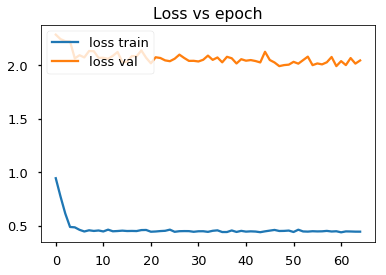

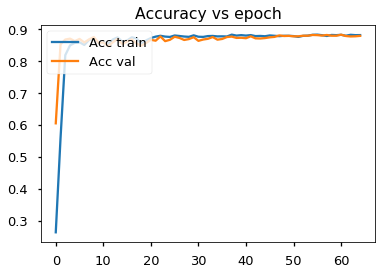

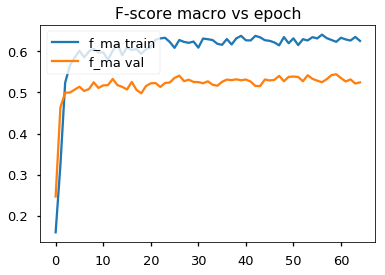

Validación final
Validando Epoch 64
loss_val: tensor(2.0627)
Acc_val: tensor(0.8801, dtype=torch.float64)
f_score_val: tensor(0.5229, dtype=torch.float64)
f_score_val: tensor([0.9302, 0.1800, 0.1217, 0.8599], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4613, dtype=torch.float64)
f_score_val: tensor([0.9290, 0.0692, 0.0118, 0.8351], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 1
f_score_val: tensor(0.4884, dtype=torch.float64)
f_score_val: tensor([0.9240, 0.1114, 0.0971, 0.8210], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 2
f_score_val: tensor(0.4811, dtype=torch.float64)
f_score_val: tensor([0.9236, 0.0979, 0.0853, 0.8177], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 3
f_score_val: tensor(0.4962, dtype=torch.float64)
f_score_val: tensor([0.9240, 0.1169, 0.1186,

Validando Epoch 47
f_score_val: tensor(0.5277, dtype=torch.float64)
f_score_val: tensor([0.9310, 0.1525, 0.1755, 0.8519], dtype=torch.float64)

0.0010416666666666667

Validando Epoch 48
f_score_val: tensor(0.5188, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.1461, 0.1478, 0.8507], dtype=torch.float64)

0.001030982623552903

Validando Epoch 49
f_score_val: tensor(0.5278, dtype=torch.float64)
f_score_val: tensor([0.9292, 0.1363, 0.1922, 0.8535], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5207, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.1407, 0.1692, 0.8430], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5124, dtype=torch.float64)
f_score_val: tensor([0.9295, 0.1223, 0.1560, 0.8417], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5341, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.1517, 0.2049, 0.8484], dtype=torch.float64)

0.0009913144821476802



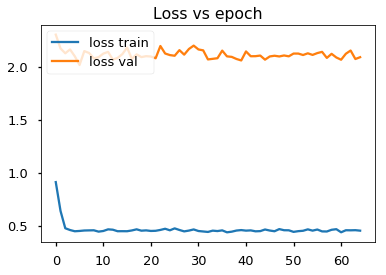

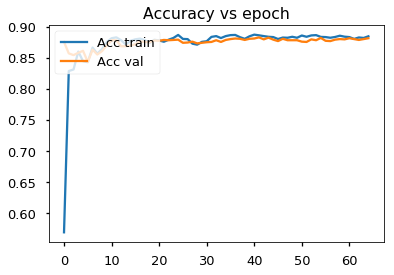

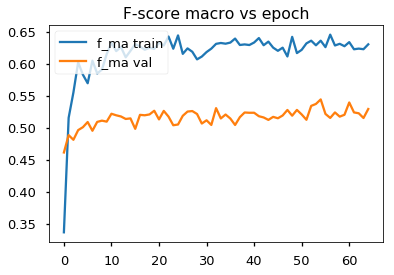

Validación final
Validando Epoch 64
loss_val: tensor(2.1080)
Acc_val: tensor(0.8791, dtype=torch.float64)
f_score_val: tensor(0.5307, dtype=torch.float64)
f_score_val: tensor([0.9315, 0.1723, 0.1755, 0.8436], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4573, dtype=torch.float64)
f_score_val: tensor([0.9035, 0.0842, 0.0000, 0.8415], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 1
f_score_val: tensor(0.4656, dtype=torch.float64)
f_score_val: tensor([0.8978, 0.1179, 0.0000, 0.8466], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 2
f_score_val: tensor(0.4966, dtype=torch.float64)
f_score_val: tensor([0.9176, 0.1446, 0.0854, 0.8389], dtype=torch.float64)

0.0029047375096555627

Validando Epoch 3
f_score_val: tensor(0.5049, dtype=torch.float64)
f_score_val: tensor([0.9165, 0.1405, 0.1217,

Validando Epoch 47
f_score_val: tensor(0.5085, dtype=torch.float64)
f_score_val: tensor([0.9344, 0.1538, 0.1039, 0.8419], dtype=torch.float64)

0.0015625

Validando Epoch 48
f_score_val: tensor(0.5127, dtype=torch.float64)
f_score_val: tensor([0.9337, 0.1717, 0.1000, 0.8452], dtype=torch.float64)

0.0015464739353293546

Validando Epoch 49
f_score_val: tensor(0.5257, dtype=torch.float64)
f_score_val: tensor([0.9311, 0.1638, 0.1569, 0.8512], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.5186, dtype=torch.float64)
f_score_val: tensor([0.9326, 0.1928, 0.0981, 0.8510], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.5175, dtype=torch.float64)
f_score_val: tensor([0.9340, 0.1648, 0.1216, 0.8497], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.5129, dtype=torch.float64)
f_score_val: tensor([0.9355, 0.1599, 0.1099, 0.8464], dtype=torch.float64)

0.0014869717232215201

Validando 

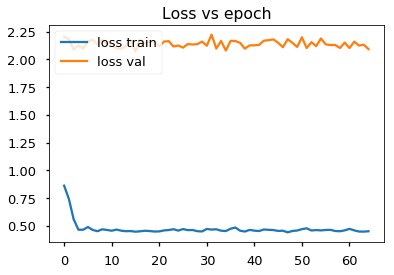

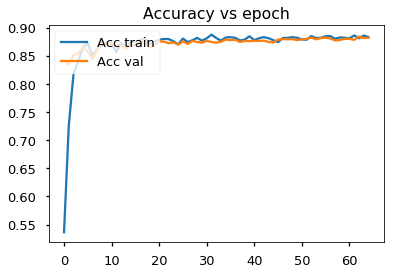

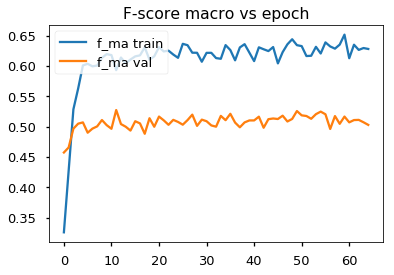

Validación final
Validando Epoch 64
loss_val: tensor(2.1169)
Acc_val: tensor(0.8805, dtype=torch.float64)
f_score_val: tensor(0.5051, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.1223, 0.1176, 0.8481], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2728, dtype=torch.float64)
f_score_val: tensor([0.7984, 0.0557, 0.0267, 0.2103], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 1
f_score_val: tensor(0.2923, dtype=torch.float64)
f_score_val: tensor([0.8106, 0.0706, 0.0300, 0.2582], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 2
f_score_val: tensor(0.3139, dtype=torch.float64)
f_score_val: tensor([0.8246, 0.0918, 0.0315, 0.3077], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 3
f_score_val: tensor(0.3555, dtype=torch.float64)
f_score_val: tensor([0.8358, 0.0852, 0.0285

Validando Epoch 47
f_score_val: tensor(0.5337, dtype=torch.float64)
f_score_val: tensor([0.9281, 0.1821, 0.1706, 0.8539], dtype=torch.float64)

0.0005208333333333333

Validando Epoch 48
f_score_val: tensor(0.5322, dtype=torch.float64)
f_score_val: tensor([0.9271, 0.1942, 0.1637, 0.8439], dtype=torch.float64)

0.0005154913117764515

Validando Epoch 49
f_score_val: tensor(0.5310, dtype=torch.float64)
f_score_val: tensor([0.9320, 0.1616, 0.1765, 0.8540], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5242, dtype=torch.float64)
f_score_val: tensor([0.9318, 0.2155, 0.1000, 0.8497], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.5253, dtype=torch.float64)
f_score_val: tensor([0.9338, 0.1832, 0.1363, 0.8478], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.5354, dtype=torch.float64)
f_score_val: tensor([0.9324, 0.1938, 0.1639, 0.8513], dtype=torch.float64)

0.0004956572410738401


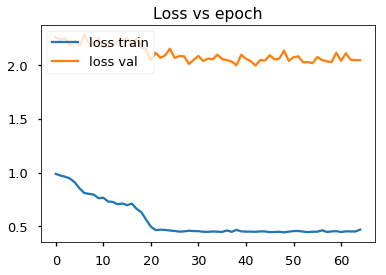

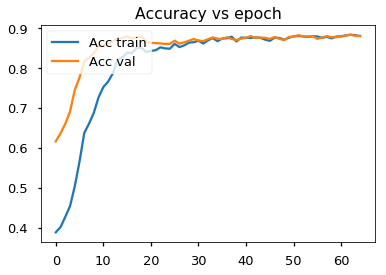

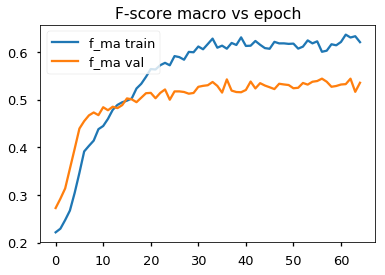

Validación final
Validando Epoch 64
loss_val: tensor(2.0191)
Acc_val: tensor(0.8791, dtype=torch.float64)
f_score_val: tensor(0.5320, dtype=torch.float64)
f_score_val: tensor([0.9320, 0.2129, 0.1368, 0.8461], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2464, dtype=torch.float64)
f_score_val: tensor([0.4598, 0.0691, 0.0146, 0.4422], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 1
f_score_val: tensor(0.3018, dtype=torch.float64)
f_score_val: tensor([0.5746, 0.0649, 0.0106, 0.5571], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 2
f_score_val: tensor(0.3418, dtype=torch.float64)
f_score_val: tensor([0.6052, 0.0945, 0.0174, 0.6500], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 3
f_score_val: tensor(0.3852, dtype=torch.float64)
f_score_val: tensor([0.7040, 0.0848, 0.020

Validando Epoch 47
f_score_val: tensor(0.5372, dtype=torch.float64)
f_score_val: tensor([0.9175, 0.2271, 0.1667, 0.8374], dtype=torch.float64)

0.0010416666666666667

Validando Epoch 48
f_score_val: tensor(0.5359, dtype=torch.float64)
f_score_val: tensor([0.9219, 0.2275, 0.1461, 0.8481], dtype=torch.float64)

0.001030982623552903

Validando Epoch 49
f_score_val: tensor(0.5318, dtype=torch.float64)
f_score_val: tensor([0.9151, 0.2036, 0.1667, 0.8419], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5276, dtype=torch.float64)
f_score_val: tensor([0.9161, 0.1864, 0.1667, 0.8413], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5371, dtype=torch.float64)
f_score_val: tensor([0.9234, 0.2091, 0.1688, 0.8470], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5235, dtype=torch.float64)
f_score_val: tensor([0.9237, 0.1885, 0.1314, 0.8504], dtype=torch.float64)

0.0009913144821476802



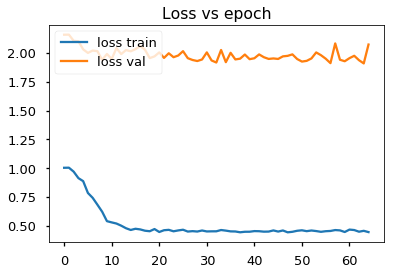

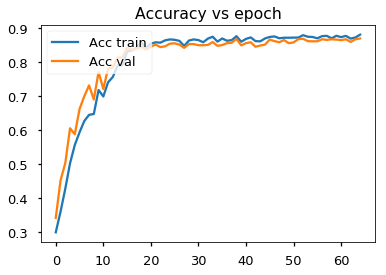

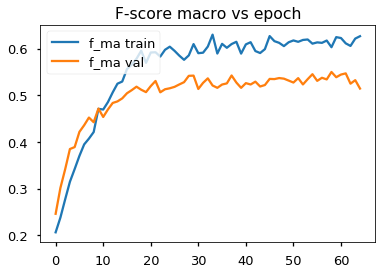

Validación final
Validando Epoch 64
loss_val: tensor(2.0499)
Acc_val: tensor(0.8713, dtype=torch.float64)
f_score_val: tensor(0.5274, dtype=torch.float64)
f_score_val: tensor([0.9255, 0.1877, 0.1441, 0.8524], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1315, dtype=torch.float64)
f_score_val: tensor([0.3460, 0.0649, 0.0062, 0.1090], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 1
f_score_val: tensor(0.2172, dtype=torch.float64)
f_score_val: tensor([0.4946, 0.0677, 0.0119, 0.2944], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 2
f_score_val: tensor(0.3252, dtype=torch.float64)
f_score_val: tensor([0.7217, 0.0636, 0.0255, 0.4901], dtype=torch.float64)

0.00019764235376052369

Validando Epoch 3
f_score_val: tensor(0.4107, dtype=torch.float64)
f_score_val: tensor([0.8645, 0.0794, 0.05

Validando Epoch 47
f_score_val: tensor(0.5088, dtype=torch.float64)
f_score_val: tensor([0.9342, 0.1104, 0.1457, 0.8452], dtype=torch.float64)

0.0015625

Validando Epoch 48
f_score_val: tensor(0.5110, dtype=torch.float64)
f_score_val: tensor([0.9355, 0.1127, 0.1422, 0.8535], dtype=torch.float64)

0.0015464739353293546

Validando Epoch 49
f_score_val: tensor(0.5197, dtype=torch.float64)
f_score_val: tensor([0.9316, 0.1394, 0.1590, 0.8486], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.5177, dtype=torch.float64)
f_score_val: tensor([0.9344, 0.1385, 0.1441, 0.8541], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.5181, dtype=torch.float64)
f_score_val: tensor([0.9328, 0.1429, 0.1510, 0.8456], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.5252, dtype=torch.float64)
f_score_val: tensor([0.9345, 0.1476, 0.1667, 0.8519], dtype=torch.float64)

0.0014869717232215201

Validando 

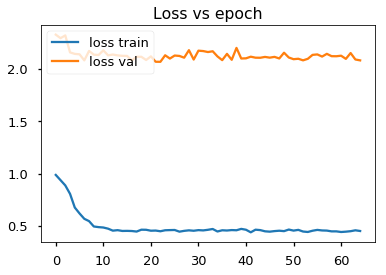

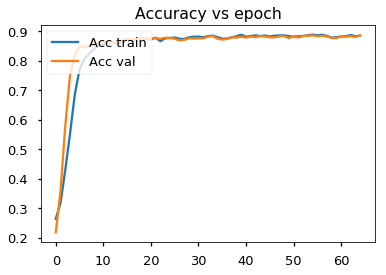

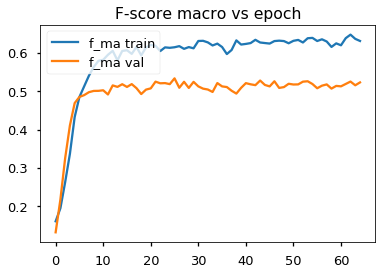

Validación final
Validando Epoch 64
loss_val: tensor(2.1357)
Acc_val: tensor(0.8847, dtype=torch.float64)
f_score_val: tensor(0.5141, dtype=torch.float64)
f_score_val: tensor([0.9327, 0.1478, 0.1235, 0.8525], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0718, dtype=torch.float64)
f_score_val: tensor([0.0423, 0.0445, 0.0204, 0.1798], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 1
f_score_val: tensor(0.0896, dtype=torch.float64)
f_score_val: tensor([0.0619, 0.0456, 0.0200, 0.2309], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 2
f_score_val: tensor(0.1359, dtype=torch.float64)
f_score_val: tensor([0.1213, 0.0456, 0.0215, 0.3554], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 3
f_score_val: tensor(0.2432, dtype=torch.float64)
f_score_val: tensor([0.3497, 0.0503, 0.0208

Validando Epoch 47
f_score_val: tensor(0.5179, dtype=torch.float64)
f_score_val: tensor([0.9247, 0.1953, 0.1172, 0.8345], dtype=torch.float64)

0.0005208333333333333

Validando Epoch 48
f_score_val: tensor(0.5121, dtype=torch.float64)
f_score_val: tensor([0.9095, 0.1870, 0.1156, 0.8365], dtype=torch.float64)

0.0005154913117764515

Validando Epoch 49
f_score_val: tensor(0.5193, dtype=torch.float64)
f_score_val: tensor([0.9138, 0.2017, 0.1237, 0.8379], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5287, dtype=torch.float64)
f_score_val: tensor([0.9171, 0.2153, 0.1452, 0.8371], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.5261, dtype=torch.float64)
f_score_val: tensor([0.9252, 0.2130, 0.1255, 0.8406], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.5167, dtype=torch.float64)
f_score_val: tensor([0.9135, 0.1776, 0.1363, 0.8393], dtype=torch.float64)

0.0004956572410738401


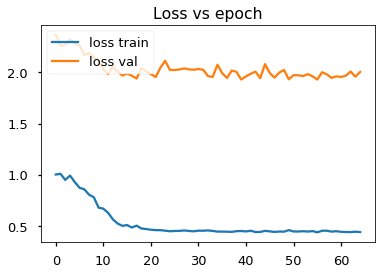

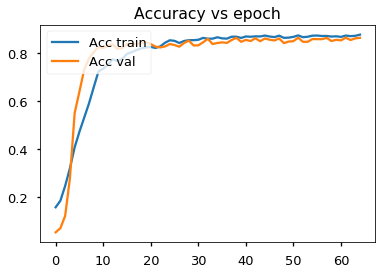

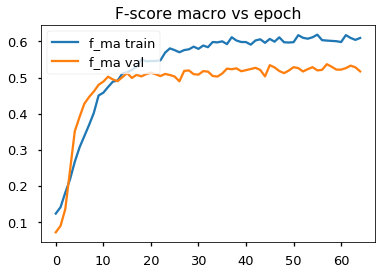

Validación final
Validando Epoch 64
loss_val: tensor(2.0521)
Acc_val: tensor(0.8644, dtype=torch.float64)
f_score_val: tensor(0.5154, dtype=torch.float64)
f_score_val: tensor([0.9260, 0.1987, 0.0996, 0.8375], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2416, dtype=torch.float64)
f_score_val: tensor([0.3221, 0.0630, 0.0400, 0.5415], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 1
f_score_val: tensor(0.2710, dtype=torch.float64)
f_score_val: tensor([0.3662, 0.0663, 0.0617, 0.5898], dtype=torch.float64)

8.784104611578831e-05

Validando Epoch 2
f_score_val: tensor(0.3159, dtype=torch.float64)
f_score_val: tensor([0.4785, 0.0766, 0.0624, 0.6461], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 3
f_score_val: tensor(0.3694, dtype=torch.float64)
f_score_val: tensor([0.6008, 0.0829, 0.068

Validando Epoch 47
f_score_val: tensor(0.5302, dtype=torch.float64)
f_score_val: tensor([0.9139, 0.1994, 0.1644, 0.8432], dtype=torch.float64)

0.0010416666666666667

Validando Epoch 48
f_score_val: tensor(0.5277, dtype=torch.float64)
f_score_val: tensor([0.8865, 0.2453, 0.1364, 0.8427], dtype=torch.float64)

0.001030982623552903

Validando Epoch 49
f_score_val: tensor(0.5315, dtype=torch.float64)
f_score_val: tensor([0.9134, 0.2470, 0.1235, 0.8422], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5246, dtype=torch.float64)
f_score_val: tensor([0.9029, 0.2420, 0.1118, 0.8418], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5461, dtype=torch.float64)
f_score_val: tensor([0.9110, 0.2942, 0.1373, 0.8420], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5119, dtype=torch.float64)
f_score_val: tensor([0.8679, 0.1869, 0.1536, 0.8389], dtype=torch.float64)

0.0009913144821476802



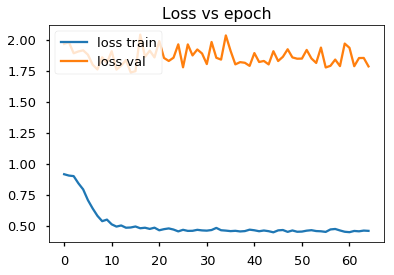

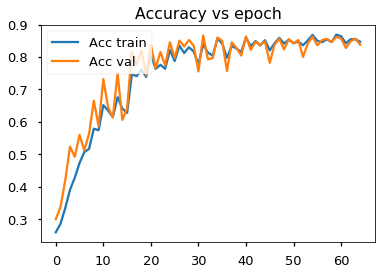

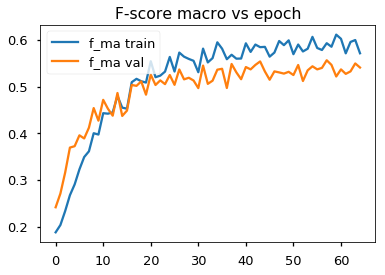

Validación final
Validando Epoch 64
loss_val: tensor(1.8005)
Acc_val: tensor(0.8369, dtype=torch.float64)
f_score_val: tensor(0.5332, dtype=torch.float64)
f_score_val: tensor([0.8963, 0.2363, 0.1590, 0.8413], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2484, dtype=torch.float64)
f_score_val: tensor([0.8480, 0.0568, 0.0233, 0.0655], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 1
f_score_val: tensor(0.2763, dtype=torch.float64)
f_score_val: tensor([0.8647, 0.0593, 0.0725, 0.1085], dtype=torch.float64)

0.00013176156917368246

Validando Epoch 2
f_score_val: tensor(0.2978, dtype=torch.float64)
f_score_val: tensor([0.8717, 0.0597, 0.0428, 0.2170], dtype=torch.float64)

0.00019764235376052369

Validando Epoch 3
f_score_val: tensor(0.3951, dtype=torch.float64)
f_score_val: tensor([0.8980, 0.0636, 0.06

Validando Epoch 47
f_score_val: tensor(0.5099, dtype=torch.float64)
f_score_val: tensor([0.9176, 0.1574, 0.1225, 0.8421], dtype=torch.float64)

0.0015625

Validando Epoch 48
f_score_val: tensor(0.5122, dtype=torch.float64)
f_score_val: tensor([0.9230, 0.1797, 0.0971, 0.8491], dtype=torch.float64)

0.0015464739353293546

Validando Epoch 49
f_score_val: tensor(0.5193, dtype=torch.float64)
f_score_val: tensor([0.9250, 0.1638, 0.1363, 0.8521], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.5098, dtype=torch.float64)
f_score_val: tensor([0.9098, 0.1669, 0.1177, 0.8448], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.5162, dtype=torch.float64)
f_score_val: tensor([0.9134, 0.1703, 0.1343, 0.8468], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.5022, dtype=torch.float64)
f_score_val: tensor([0.9179, 0.1535, 0.0923, 0.8450], dtype=torch.float64)

0.0014869717232215201

Validando 

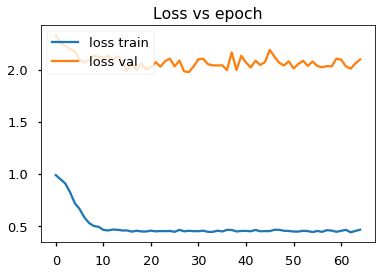

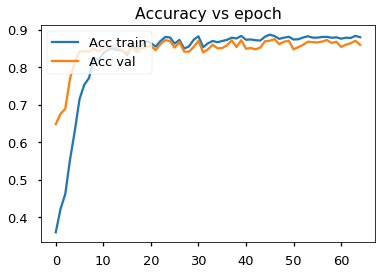

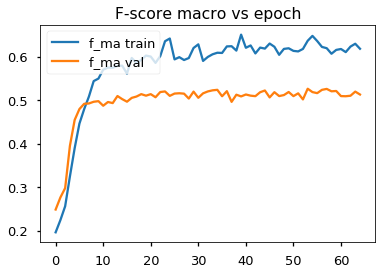

Validación final
Validando Epoch 64
loss_val: tensor(2.0704)
Acc_val: tensor(0.8594, dtype=torch.float64)
f_score_val: tensor(0.5165, dtype=torch.float64)
f_score_val: tensor([0.9161, 0.1591, 0.1363, 0.8544], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0612, dtype=torch.float64)
f_score_val: tensor([0.1321, 0.0534, 0.0168, 0.0425], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 1
f_score_val: tensor(0.0641, dtype=torch.float64)
f_score_val: tensor([0.1428, 0.0540, 0.0173, 0.0423], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 2
f_score_val: tensor(0.0748, dtype=torch.float64)
f_score_val: tensor([0.1787, 0.0549, 0.0214, 0.0441], dtype=torch.float64)

3.061862178478972e-05

Validando Epoch 3
f_score_val: tensor(0.0922, dtype=torch.float64)
f_score_val: tensor([0.2440, 0.0589, 0.01

Validando Epoch 47
f_score_val: tensor(0.5126, dtype=torch.float64)
f_score_val: tensor([0.9041, 0.1782, 0.1280, 0.8398], dtype=torch.float64)

0.0004898979485566356

Validando Epoch 48
f_score_val: tensor(0.5405, dtype=torch.float64)
f_score_val: tensor([0.8991, 0.2346, 0.1824, 0.8459], dtype=torch.float64)

0.0005001041558182321

Validando Epoch 49
f_score_val: tensor(0.5114, dtype=torch.float64)
f_score_val: tensor([0.8701, 0.1827, 0.1467, 0.8460], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5314, dtype=torch.float64)
f_score_val: tensor([0.8965, 0.2357, 0.1495, 0.8440], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.5230, dtype=torch.float64)
f_score_val: tensor([0.8802, 0.1924, 0.1739, 0.8457], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.5395, dtype=torch.float64)
f_score_val: tensor([0.9005, 0.2297, 0.1775, 0.8504], dtype=torch.float64)

0.0004956572410738401


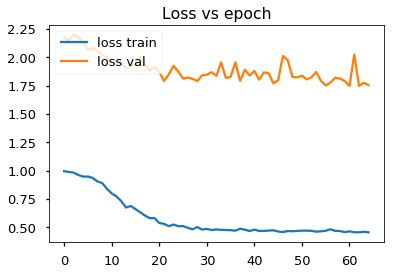

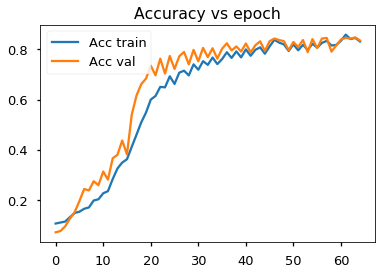

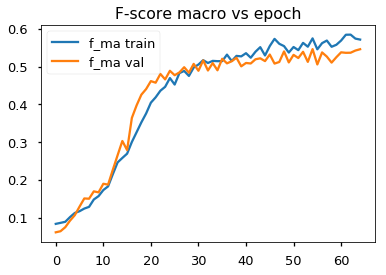

Validación final
Validando Epoch 64
loss_val: tensor(1.7827)
Acc_val: tensor(0.8355, dtype=torch.float64)
f_score_val: tensor(0.5422, dtype=torch.float64)
f_score_val: tensor([0.8992, 0.2579, 0.1578, 0.8537], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1461, dtype=torch.float64)
f_score_val: tensor([0.0232, 0.0820, 0.0256, 0.4535], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 1
f_score_val: tensor(0.1487, dtype=torch.float64)
f_score_val: tensor([0.0267, 0.0804, 0.0256, 0.4621], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 2
f_score_val: tensor(0.1522, dtype=torch.float64)
f_score_val: tensor([0.0286, 0.0765, 0.0289, 0.4748], dtype=torch.float64)

6.123724356957945e-05

Validando Epoch 3
f_score_val: tensor(0.1668, dtype=torch.float64)
f_score_val: tensor([0.0377, 0.0917, 0.029

Validando Epoch 47
f_score_val: tensor(0.5263, dtype=torch.float64)
f_score_val: tensor([0.9182, 0.2135, 0.1284, 0.8452], dtype=torch.float64)

0.0009797958971132711

Validando Epoch 48
f_score_val: tensor(0.5228, dtype=torch.float64)
f_score_val: tensor([0.9215, 0.2021, 0.1216, 0.8462], dtype=torch.float64)

0.0010002083116364643

Validando Epoch 49
f_score_val: tensor(0.5235, dtype=torch.float64)
f_score_val: tensor([0.9209, 0.2066, 0.1176, 0.8490], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5349, dtype=torch.float64)
f_score_val: tensor([0.9131, 0.2006, 0.1912, 0.8346], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5226, dtype=torch.float64)
f_score_val: tensor([0.9193, 0.2090, 0.1209, 0.8412], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5231, dtype=torch.float64)
f_score_val: tensor([0.9230, 0.1958, 0.1392, 0.8346], dtype=torch.float64)

0.0009913144821476802


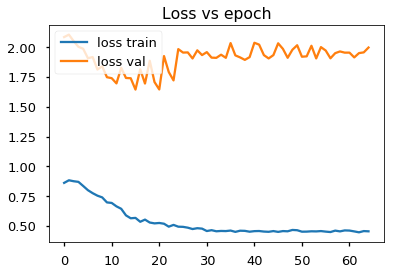

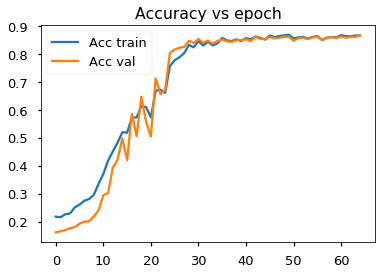

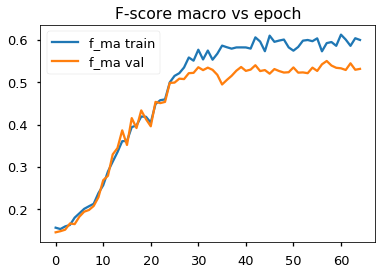

Validación final
Validando Epoch 64
loss_val: tensor(2.0208)
Acc_val: tensor(0.8672, dtype=torch.float64)
f_score_val: tensor(0.5383, dtype=torch.float64)
f_score_val: tensor([0.9249, 0.2170, 0.1608, 0.8503], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 64  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0626, dtype=torch.float64)
f_score_val: tensor([0.0085, 0.0607, 0.0118, 0.1695], dtype=torch.float64)

3.0618621784789716e-05

Validando Epoch 1
f_score_val: tensor(0.0826, dtype=torch.float64)
f_score_val: tensor([0.0092, 0.0700, 0.0294, 0.2217], dtype=torch.float64)

6.123724356957943e-05

Validando Epoch 2
f_score_val: tensor(0.0964, dtype=torch.float64)
f_score_val: tensor([0.0124, 0.0690, 0.0118, 0.2922], dtype=torch.float64)

9.185586535436917e-05

Validando Epoch 3
f_score_val: tensor(0.1243, dtype=torch.float64)
f_score_val: tensor([0.0179, 0.0731, 0.011

Validando Epoch 47
f_score_val: tensor(0.5078, dtype=torch.float64)
f_score_val: tensor([0.9086, 0.1725, 0.1000, 0.8502], dtype=torch.float64)

0.0014696938456699067

Validando Epoch 48
f_score_val: tensor(0.4747, dtype=torch.float64)
f_score_val: tensor([0.7946, 0.1411, 0.1196, 0.8433], dtype=torch.float64)

0.0015003124674546964

Validando Epoch 49
f_score_val: tensor(0.3245, dtype=torch.float64)
f_score_val: tensor([0.2500, 0.0805, 0.1237, 0.8440], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.4870, dtype=torch.float64)
f_score_val: tensor([0.8461, 0.1444, 0.1144, 0.8430], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.2954, dtype=torch.float64)
f_score_val: tensor([0.1270, 0.0733, 0.1373, 0.8440], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.3326, dtype=torch.float64)
f_score_val: tensor([0.2868, 0.0881, 0.1094, 0.8459], dtype=torch.float64)

0.0014869717232215201

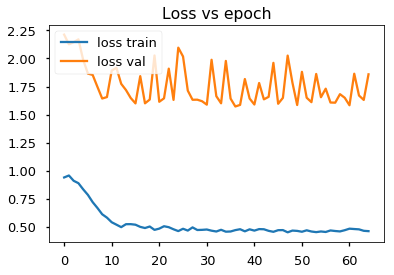

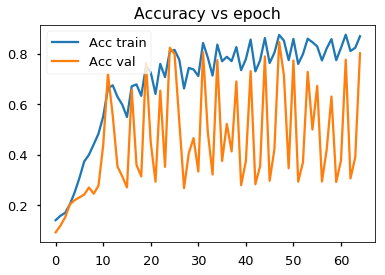

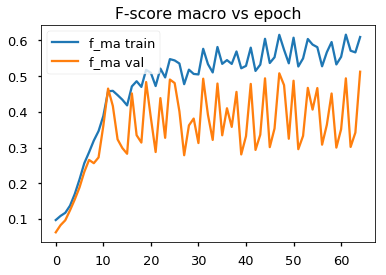

Validación final
Validando Epoch 64
loss_val: tensor(1.8923)
Acc_val: tensor(0.8019, dtype=torch.float64)
f_score_val: tensor(0.5049, dtype=torch.float64)
f_score_val: tensor([0.8704, 0.1854, 0.1186, 0.8451], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0601, dtype=torch.float64)
f_score_val: tensor([0.1313, 0.0650, 0.0304, 0.0139], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 1
f_score_val: tensor(0.0637, dtype=torch.float64)
f_score_val: tensor([0.1372, 0.0668, 0.0392, 0.0115], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 2
f_score_val: tensor(0.0664, dtype=torch.float64)
f_score_val: tensor([0.1504, 0.0691, 0.0363, 0.0100], dtype=torch.float64)

3.061862178478972e-05

Validando Epoch 3
f_score_val: tensor(0.0728, dtype=torch.float64)
f_score_val: tensor([0.1716, 0.0700, 0.04

Validando Epoch 47
f_score_val: tensor(0.3694, dtype=torch.float64)
f_score_val: tensor([0.4836, 0.1024, 0.0889, 0.8027], dtype=torch.float64)

0.0004898979485566356

Validando Epoch 48
f_score_val: tensor(0.4511, dtype=torch.float64)
f_score_val: tensor([0.7292, 0.1729, 0.1179, 0.7845], dtype=torch.float64)

0.0005001041558182321

Validando Epoch 49
f_score_val: tensor(0.4350, dtype=torch.float64)
f_score_val: tensor([0.6716, 0.1472, 0.1292, 0.7921], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.4969, dtype=torch.float64)
f_score_val: tensor([0.8907, 0.1398, 0.1408, 0.8161], dtype=torch.float64)

0.000505282552159027

Validando Epoch 51
f_score_val: tensor(0.4777, dtype=torch.float64)
f_score_val: tensor([0.8216, 0.1613, 0.1151, 0.8129], dtype=torch.float64)

0.0005004004806408972

Validando Epoch 52
f_score_val: tensor(0.4785, dtype=torch.float64)
f_score_val: tensor([0.8205, 0.1482, 0.1142, 0.8310], dtype=torch.float64)

0.0004956572410738401


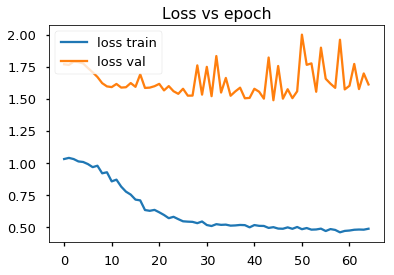

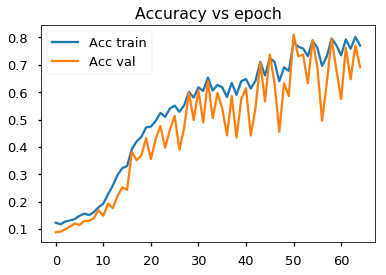

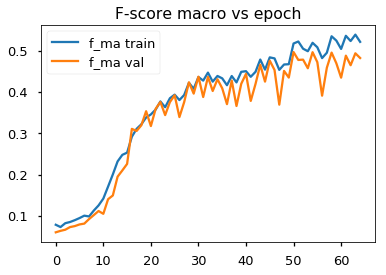

Validación final
Validando Epoch 64
loss_val: tensor(1.6281)
Acc_val: tensor(0.6916, dtype=torch.float64)
f_score_val: tensor(0.4793, dtype=torch.float64)
f_score_val: tensor([0.7684, 0.1625, 0.1486, 0.8374], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1890, dtype=torch.float64)
f_score_val: tensor([0.5644, 0.0464, 0.0213, 0.1238], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 1
f_score_val: tensor(0.1990, dtype=torch.float64)
f_score_val: tensor([0.5798, 0.0533, 0.0193, 0.1436], dtype=torch.float64)

4.082482904638629e-05

Validando Epoch 2
f_score_val: tensor(0.2122, dtype=torch.float64)
f_score_val: tensor([0.5931, 0.0642, 0.0228, 0.1688], dtype=torch.float64)

6.123724356957945e-05

Validando Epoch 3
f_score_val: tensor(0.2317, dtype=torch.float64)
f_score_val: tensor([0.5895, 0.0600, 0.035

Validando Epoch 47
f_score_val: tensor(0.5383, dtype=torch.float64)
f_score_val: tensor([0.9266, 0.2202, 0.1657, 0.8408], dtype=torch.float64)

0.0009797958971132711

Validando Epoch 48
f_score_val: tensor(0.5164, dtype=torch.float64)
f_score_val: tensor([0.9288, 0.1763, 0.1412, 0.8193], dtype=torch.float64)

0.0010002083116364643

Validando Epoch 49
f_score_val: tensor(0.5358, dtype=torch.float64)
f_score_val: tensor([0.9287, 0.2445, 0.1373, 0.8329], dtype=torch.float64)

0.0010206207261596574

Validando Epoch 50
f_score_val: tensor(0.5272, dtype=torch.float64)
f_score_val: tensor([0.9280, 0.2018, 0.1451, 0.8339], dtype=torch.float64)

0.001010565104318054

Validando Epoch 51
f_score_val: tensor(0.5288, dtype=torch.float64)
f_score_val: tensor([0.9186, 0.2469, 0.1137, 0.8361], dtype=torch.float64)

0.0010008009612817944

Validando Epoch 52
f_score_val: tensor(0.5136, dtype=torch.float64)
f_score_val: tensor([0.9181, 0.1763, 0.1300, 0.8298], dtype=torch.float64)

0.0009913144821476802


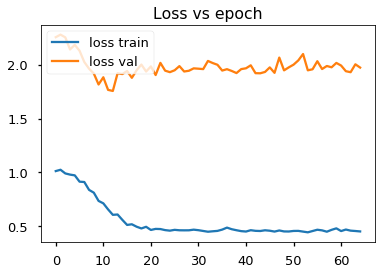

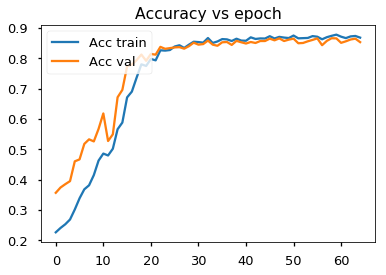

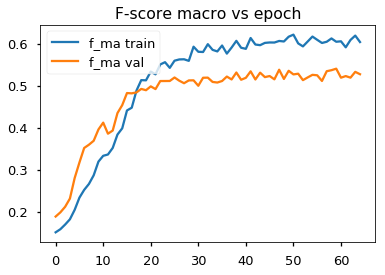

Validación final
Validando Epoch 64
loss_val: tensor(1.9561)
Acc_val: tensor(0.8543, dtype=torch.float64)
f_score_val: tensor(0.5186, dtype=torch.float64)
f_score_val: tensor([0.9193, 0.2002, 0.1223, 0.8327], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 64  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2726, dtype=torch.float64)
f_score_val: tensor([0.9026, 0.0447, 0.0609, 0.0823], dtype=torch.float64)

3.0618621784789716e-05

Validando Epoch 1
f_score_val: tensor(0.2716, dtype=torch.float64)
f_score_val: tensor([0.9046, 0.0456, 0.0505, 0.0857], dtype=torch.float64)

6.123724356957943e-05

Validando Epoch 2
f_score_val: tensor(0.2813, dtype=torch.float64)
f_score_val: tensor([0.9097, 0.0643, 0.0703, 0.0811], dtype=torch.float64)

9.185586535436917e-05

Validando Epoch 3
f_score_val: tensor(0.2869, dtype=torch.float64)
f_score_val: tensor([0.9145, 0.0578, 0.075

Validando Epoch 47
f_score_val: tensor(0.5135, dtype=torch.float64)
f_score_val: tensor([0.9078, 0.1866, 0.1237, 0.8360], dtype=torch.float64)

0.0014696938456699067

Validando Epoch 48
f_score_val: tensor(0.5067, dtype=torch.float64)
f_score_val: tensor([0.9106, 0.1712, 0.1054, 0.8398], dtype=torch.float64)

0.0015003124674546964

Validando Epoch 49
f_score_val: tensor(0.5022, dtype=torch.float64)
f_score_val: tensor([0.9163, 0.1676, 0.0756, 0.8492], dtype=torch.float64)

0.0015309310892394862

Validando Epoch 50
f_score_val: tensor(0.5147, dtype=torch.float64)
f_score_val: tensor([0.9234, 0.1977, 0.0971, 0.8406], dtype=torch.float64)

0.0015158476564770809

Validando Epoch 51
f_score_val: tensor(0.5110, dtype=torch.float64)
f_score_val: tensor([0.9282, 0.1650, 0.1167, 0.8342], dtype=torch.float64)

0.0015012014419226918

Validando Epoch 52
f_score_val: tensor(0.5095, dtype=torch.float64)
f_score_val: tensor([0.9162, 0.1780, 0.1088, 0.8351], dtype=torch.float64)

0.0014869717232215201

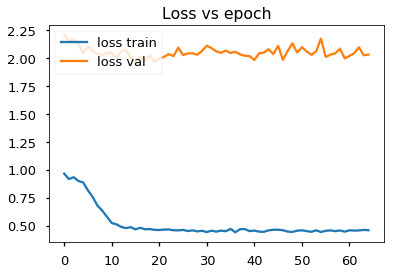

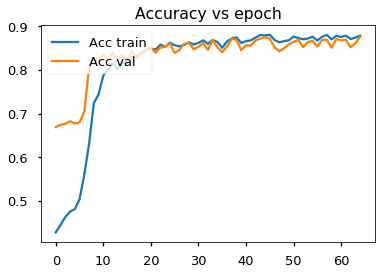

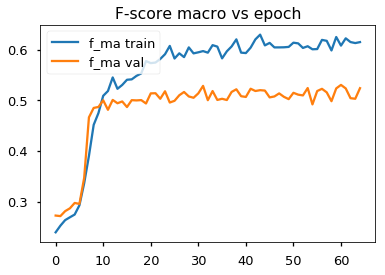

Validación final
Validando Epoch 64
loss_val: tensor(2.1171)
Acc_val: tensor(0.8732, dtype=torch.float64)
f_score_val: tensor(0.5291, dtype=torch.float64)
f_score_val: tensor([0.9269, 0.2358, 0.1029, 0.8507], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1011, dtype=torch.float64)
f_score_val: tensor([0.2246, 0.0411, 0.0233, 0.1153], dtype=torch.float64)

0.0001613743060919757

Validando Epoch 1
f_score_val: tensor(0.2989, dtype=torch.float64)
f_score_val: tensor([0.5645, 0.0270, 0.0249, 0.5793], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 2
f_score_val: tensor(0.4161, dtype=torch.float64)
f_score_val: tensor([0.7999, 0.0315, 0.0389, 0.7940], dtype=torch.float64)

0.0004841229182759271

Validando Epoch 3
f_score_val: tensor(0.4844, dtype=torch.float64)
f_score_val: tensor([0.9243, 0.1046, 0.0990

Validando Epoch 47
f_score_val: tensor(0.5374, dtype=torch.float64)
f_score_val: tensor([0.9330, 0.1656, 0.1974, 0.8537], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.5467, dtype=torch.float64)
f_score_val: tensor([0.9339, 0.1660, 0.2345, 0.8524], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.5488, dtype=torch.float64)
f_score_val: tensor([0.9344, 0.1596, 0.2521, 0.8491], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.5476, dtype=torch.float64)
f_score_val: tensor([0.9341, 0.1487, 0.2527, 0.8550], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.5522, dtype=torch.float64)
f_score_val: tensor([0.9349, 0.1664, 0.2562, 0.8513], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.5560, dtype=torch.float64)
f_score_val: tensor([0.9358, 0.1712, 0.2609, 0.8560], dtype=torch.float64)

0.0007009651926150552


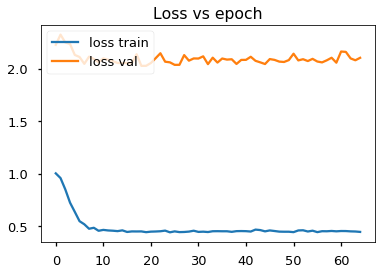

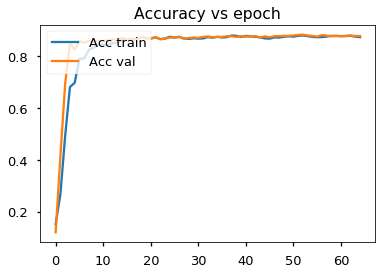

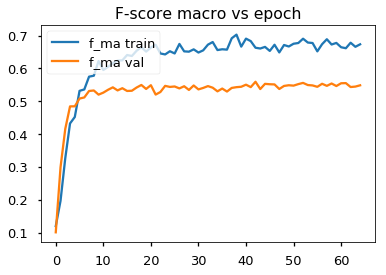

Validación final
Validando Epoch 64
loss_val: tensor(2.0996)
Acc_val: tensor(0.8810, dtype=torch.float64)
f_score_val: tensor(0.5459, dtype=torch.float64)
f_score_val: tensor([0.9358, 0.1580, 0.2356, 0.8542], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.3639, dtype=torch.float64)
f_score_val: tensor([0.6149, 0.0861, 0.0639, 0.6909], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 1
f_score_val: tensor(0.4717, dtype=torch.float64)
f_score_val: tensor([0.8627, 0.1084, 0.1157, 0.7998], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 2
f_score_val: tensor(0.5040, dtype=torch.float64)
f_score_val: tensor([0.9002, 0.1534, 0.1394, 0.8229], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 3
f_score_val: tensor(0.5016, dtype=torch.float64)
f_score_val: tensor([0.9028, 0.1556, 0.1235

Validando Epoch 47
f_score_val: tensor(0.5202, dtype=torch.float64)
f_score_val: tensor([0.9249, 0.1376, 0.1709, 0.8474], dtype=torch.float64)

0.001473139127471974

Validando Epoch 48
f_score_val: tensor(0.5373, dtype=torch.float64)
f_score_val: tensor([0.9250, 0.1732, 0.2018, 0.8491], dtype=torch.float64)

0.0014580296087995106

Validando Epoch 49
f_score_val: tensor(0.5409, dtype=torch.float64)
f_score_val: tensor([0.9268, 0.1288, 0.2608, 0.8473], dtype=torch.float64)

0.0014433756729740643

Validando Epoch 50
f_score_val: tensor(0.5231, dtype=torch.float64)
f_score_val: tensor([0.9302, 0.1670, 0.1498, 0.8453], dtype=torch.float64)

0.0014291548761875736

Validando Epoch 51
f_score_val: tensor(0.5272, dtype=torch.float64)
f_score_val: tensor([0.9269, 0.1461, 0.1881, 0.8478], dtype=torch.float64)

0.0014153462926807447

Validando Epoch 52
f_score_val: tensor(0.5242, dtype=torch.float64)
f_score_val: tensor([0.9281, 0.1414, 0.1810, 0.8461], dtype=torch.float64)

0.0014019303852301104


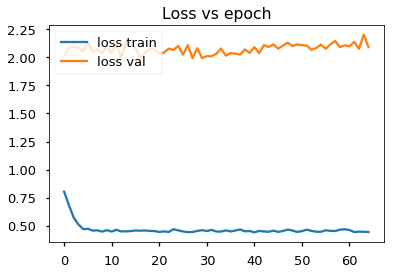

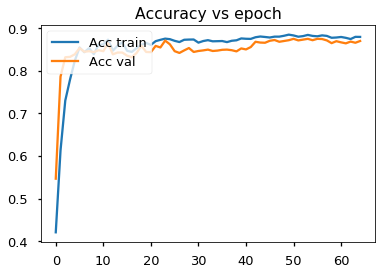

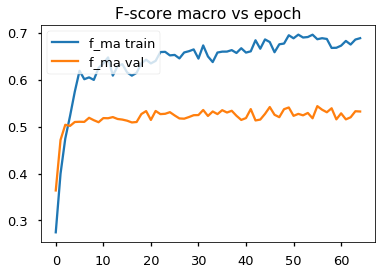

Validación final
Validando Epoch 64
loss_val: tensor(2.1675)
Acc_val: tensor(0.8686, dtype=torch.float64)
f_score_val: tensor(0.5338, dtype=torch.float64)
f_score_val: tensor([0.9274, 0.1747, 0.1882, 0.8450], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1964, dtype=torch.float64)
f_score_val: tensor([0.5632, 0.0779, 0.0437, 0.1009], dtype=torch.float64)

0.0004841229182759271

Validando Epoch 1
f_score_val: tensor(0.4084, dtype=torch.float64)
f_score_val: tensor([0.8094, 0.1138, 0.0879, 0.6227], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 2
f_score_val: tensor(0.4767, dtype=torch.float64)
f_score_val: tensor([0.8933, 0.1604, 0.1053, 0.7477], dtype=torch.float64)

0.0014523687548277813

Validando Epoch 3
f_score_val: tensor(0.4970, dtype=torch.float64)
f_score_val: tensor([0.8953, 0.1785, 0.1254

Validando Epoch 47
f_score_val: tensor(0.5365, dtype=torch.float64)
f_score_val: tensor([0.9193, 0.1897, 0.1909, 0.8462], dtype=torch.float64)

0.002209708691207961

Validando Epoch 48
f_score_val: tensor(0.5453, dtype=torch.float64)
f_score_val: tensor([0.9217, 0.1883, 0.2253, 0.8461], dtype=torch.float64)

0.002187044413199266

Validando Epoch 49
f_score_val: tensor(0.5446, dtype=torch.float64)
f_score_val: tensor([0.9229, 0.1971, 0.2120, 0.8465], dtype=torch.float64)

0.0021650635094610966

Validando Epoch 50
f_score_val: tensor(0.5553, dtype=torch.float64)
f_score_val: tensor([0.9208, 0.1758, 0.2751, 0.8493], dtype=torch.float64)

0.0021437323142813602

Validando Epoch 51
f_score_val: tensor(0.5572, dtype=torch.float64)
f_score_val: tensor([0.9255, 0.2165, 0.2403, 0.8463], dtype=torch.float64)

0.002123019439021117

Validando Epoch 52
f_score_val: tensor(0.5571, dtype=torch.float64)
f_score_val: tensor([0.9259, 0.2067, 0.2496, 0.8463], dtype=torch.float64)

0.0021028955778451654

V

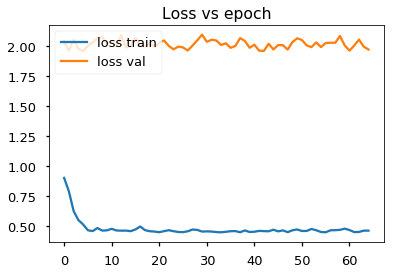

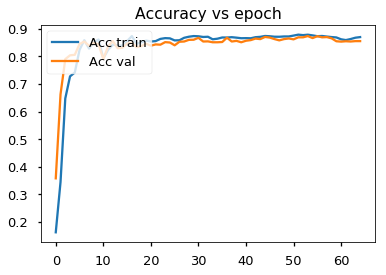

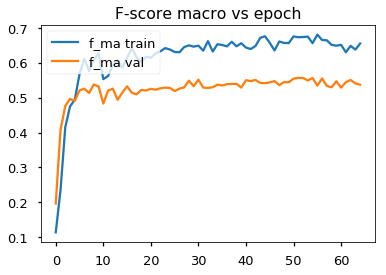

Validación final
Validando Epoch 64
loss_val: tensor(1.9789)
Acc_val: tensor(0.8552, dtype=torch.float64)
f_score_val: tensor(0.5480, dtype=torch.float64)
f_score_val: tensor([0.9164, 0.2165, 0.2158, 0.8433], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0905, dtype=torch.float64)
f_score_val: tensor([0.1150, 0.0356, 0.0282, 0.1834], dtype=torch.float64)

0.0001613743060919757

Validando Epoch 1
f_score_val: tensor(0.1294, dtype=torch.float64)
f_score_val: tensor([0.1851, 0.0502, 0.0324, 0.2499], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 2
f_score_val: tensor(0.2712, dtype=torch.float64)
f_score_val: tensor([0.4811, 0.0651, 0.0544, 0.4841], dtype=torch.float64)

0.0004841229182759271

Validando Epoch 3
f_score_val: tensor(0.2585, dtype=torch.float64)
f_score_val: tensor([0.2403, 0.0648, 0.0592

Validando Epoch 47
f_score_val: tensor(0.4429, dtype=torch.float64)
f_score_val: tensor([0.6344, 0.1283, 0.1746, 0.8343], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4968, dtype=torch.float64)
f_score_val: tensor([0.7909, 0.1870, 0.1802, 0.8292], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4645, dtype=torch.float64)
f_score_val: tensor([0.6593, 0.1278, 0.2276, 0.8434], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.5168, dtype=torch.float64)
f_score_val: tensor([0.8384, 0.2089, 0.1824, 0.8377], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4261, dtype=torch.float64)
f_score_val: tensor([0.5816, 0.1180, 0.1647, 0.8402], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4522, dtype=torch.float64)
f_score_val: tensor([0.6449, 0.1310, 0.1905, 0.8422], dtype=torch.float64)

0.0007009651926150552


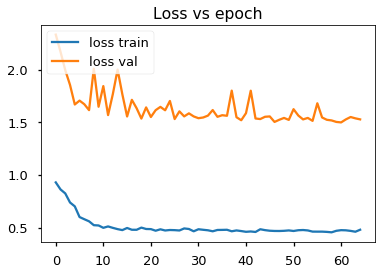

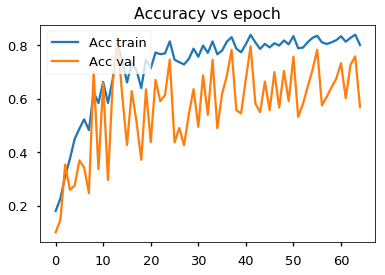

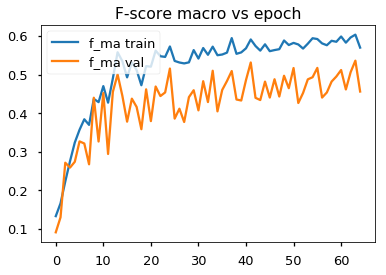

Validación final
Validando Epoch 64
loss_val: tensor(1.5204)
Acc_val: tensor(0.5685, dtype=torch.float64)
f_score_val: tensor(0.4477, dtype=torch.float64)
f_score_val: tensor([0.6347, 0.1283, 0.1907, 0.8372], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.3631, dtype=torch.float64)
f_score_val: tensor([0.8779, 0.0662, 0.0626, 0.4457], dtype=torch.float64)

0.0003227486121839514

Validando Epoch 1
f_score_val: tensor(0.4336, dtype=torch.float64)
f_score_val: tensor([0.8714, 0.0636, 0.1209, 0.6784], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 2
f_score_val: tensor(0.4533, dtype=torch.float64)
f_score_val: tensor([0.8728, 0.0770, 0.1032, 0.7600], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 3
f_score_val: tensor(0.4701, dtype=torch.float64)
f_score_val: tensor([0.8642, 0.1256, 0.1265

Validando Epoch 47
f_score_val: tensor(0.5216, dtype=torch.float64)
f_score_val: tensor([0.9111, 0.1730, 0.1677, 0.8348], dtype=torch.float64)

0.001473139127471974

Validando Epoch 48
f_score_val: tensor(0.5367, dtype=torch.float64)
f_score_val: tensor([0.9145, 0.1854, 0.2103, 0.8366], dtype=torch.float64)

0.0014580296087995106

Validando Epoch 49
f_score_val: tensor(0.5397, dtype=torch.float64)
f_score_val: tensor([0.9142, 0.1845, 0.2276, 0.8324], dtype=torch.float64)

0.0014433756729740643

Validando Epoch 50
f_score_val: tensor(0.5202, dtype=torch.float64)
f_score_val: tensor([0.9163, 0.1687, 0.1558, 0.8401], dtype=torch.float64)

0.0014291548761875736

Validando Epoch 51
f_score_val: tensor(0.5396, dtype=torch.float64)
f_score_val: tensor([0.9182, 0.2061, 0.1931, 0.8409], dtype=torch.float64)

0.0014153462926807447

Validando Epoch 52
f_score_val: tensor(0.5388, dtype=torch.float64)
f_score_val: tensor([0.9205, 0.2079, 0.1923, 0.8344], dtype=torch.float64)

0.0014019303852301104


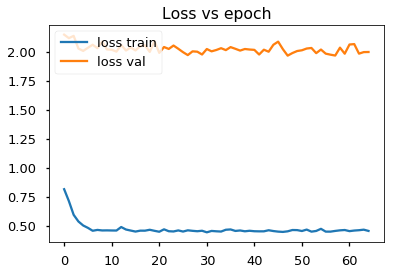

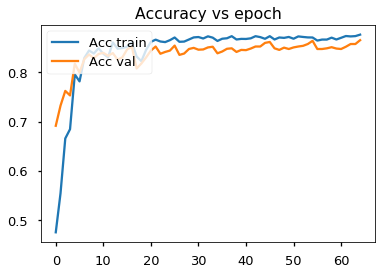

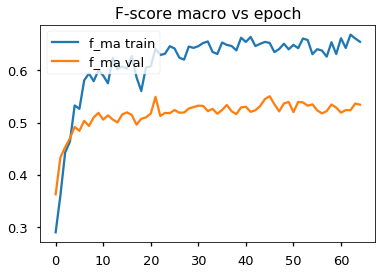

Validación final
Validando Epoch 64
loss_val: tensor(2.0636)
Acc_val: tensor(0.8658, dtype=torch.float64)
f_score_val: tensor(0.5367, dtype=torch.float64)
f_score_val: tensor([0.9270, 0.2451, 0.1373, 0.8373], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4253, dtype=torch.float64)
f_score_val: tensor([0.8791, 0.0979, 0.0147, 0.7095], dtype=torch.float64)

0.0004841229182759271

Validando Epoch 1
f_score_val: tensor(0.4935, dtype=torch.float64)
f_score_val: tensor([0.9079, 0.1596, 0.0882, 0.8181], dtype=torch.float64)

0.0009682458365518542

Validando Epoch 2
f_score_val: tensor(0.4984, dtype=torch.float64)
f_score_val: tensor([0.9051, 0.1727, 0.0942, 0.8218], dtype=torch.float64)

0.0014523687548277813

Validando Epoch 3
f_score_val: tensor(0.5146, dtype=torch.float64)
f_score_val: tensor([0.9064, 0.1904, 0.1457

Validando Epoch 47
f_score_val: tensor(0.5345, dtype=torch.float64)
f_score_val: tensor([0.9337, 0.2116, 0.1465, 0.8464], dtype=torch.float64)

0.002209708691207961

Validando Epoch 48
f_score_val: tensor(0.5255, dtype=torch.float64)
f_score_val: tensor([0.9267, 0.1627, 0.1699, 0.8427], dtype=torch.float64)

0.002187044413199266

Validando Epoch 49
f_score_val: tensor(0.5179, dtype=torch.float64)
f_score_val: tensor([0.9275, 0.1764, 0.1268, 0.8410], dtype=torch.float64)

0.0021650635094610966

Validando Epoch 50
f_score_val: tensor(0.5193, dtype=torch.float64)
f_score_val: tensor([0.9286, 0.1714, 0.1398, 0.8373], dtype=torch.float64)

0.0021437323142813602

Validando Epoch 51
f_score_val: tensor(0.5202, dtype=torch.float64)
f_score_val: tensor([0.9299, 0.1644, 0.1437, 0.8429], dtype=torch.float64)

0.002123019439021117

Validando Epoch 52
f_score_val: tensor(0.5319, dtype=torch.float64)
f_score_val: tensor([0.9304, 0.1976, 0.1542, 0.8452], dtype=torch.float64)

0.0021028955778451654

V

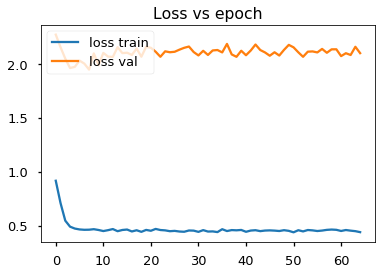

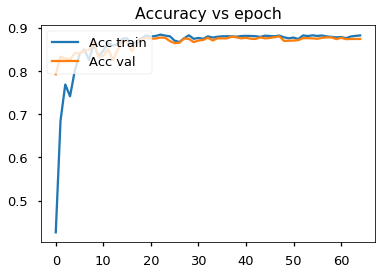

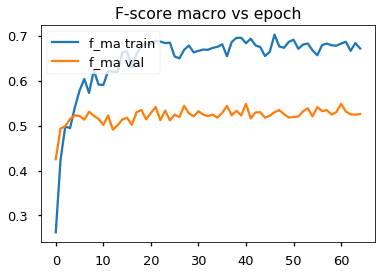

Validación final
Validando Epoch 64
loss_val: tensor(2.0846)
Acc_val: tensor(0.8773, dtype=torch.float64)
f_score_val: tensor(0.5267, dtype=torch.float64)
f_score_val: tensor([0.9305, 0.1523, 0.1771, 0.8470], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2527, dtype=torch.float64)
f_score_val: tensor([0.1574, 0.0540, 0.0139, 0.7856], dtype=torch.float64)

1.098013076447354e-05

Validando Epoch 1
f_score_val: tensor(0.2650, dtype=torch.float64)
f_score_val: tensor([0.1784, 0.0681, 0.0136, 0.8000], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 2
f_score_val: tensor(0.2689, dtype=torch.float64)
f_score_val: tensor([0.2111, 0.0521, 0.0142, 0.7983], dtype=torch.float64)

3.2940392293420614e-05

Validando Epoch 3
f_score_val: tensor(0.2853, dtype=torch.float64)
f_score_val: tensor([0.2530, 0.0681, 0.01

Validando Epoch 47
f_score_val: tensor(0.4788, dtype=torch.float64)
f_score_val: tensor([0.7919, 0.1330, 0.1450, 0.8455], dtype=torch.float64)

0.0005270462766947298

Validando Epoch 48
f_score_val: tensor(0.5021, dtype=torch.float64)
f_score_val: tensor([0.8390, 0.1579, 0.1659, 0.8457], dtype=torch.float64)

0.0005380264074592034

Validando Epoch 49
f_score_val: tensor(0.5142, dtype=torch.float64)
f_score_val: tensor([0.8570, 0.1635, 0.1912, 0.8450], dtype=torch.float64)

0.0005490065382236769

Validando Epoch 50
f_score_val: tensor(0.5379, dtype=torch.float64)
f_score_val: tensor([0.8992, 0.2225, 0.1833, 0.8465], dtype=torch.float64)

0.0005599866689881504

Validando Epoch 51
f_score_val: tensor(0.5108, dtype=torch.float64)
f_score_val: tensor([0.8401, 0.1618, 0.1988, 0.8424], dtype=torch.float64)

0.0005709667997526239

Validando Epoch 52
f_score_val: tensor(0.5000, dtype=torch.float64)
f_score_val: tensor([0.8307, 0.1482, 0.1730, 0.8480], dtype=torch.float64)

0.0005819469305170975

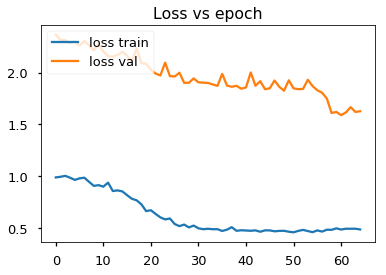

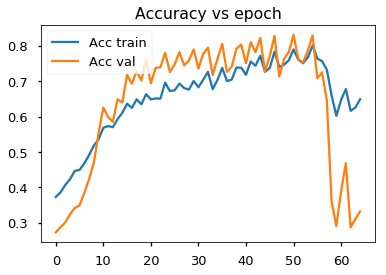

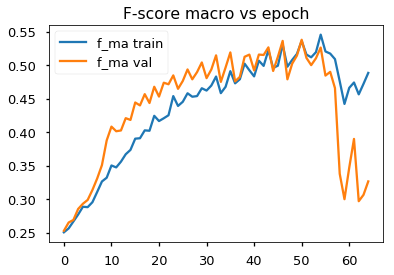

Validación final
Validando Epoch 64
loss_val: tensor(1.6761)
Acc_val: tensor(0.3332, dtype=torch.float64)
f_score_val: tensor(0.3357, dtype=torch.float64)
f_score_val: tensor([0.2142, 0.0810, 0.1982, 0.8492], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0877, dtype=torch.float64)
f_score_val: tensor([0.0288, 0.0334, 0.0207, 0.2680], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 1
f_score_val: tensor(0.0991, dtype=torch.float64)
f_score_val: tensor([0.0499, 0.0316, 0.0234, 0.2914], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 2
f_score_val: tensor(0.1084, dtype=torch.float64)
f_score_val: tensor([0.0624, 0.0287, 0.0224, 0.3204], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 3
f_score_val: tensor(0.1238, dtype=torch.float64)
f_score_val: tensor([0.1030, 0.0352, 0.025

Validando Epoch 47
f_score_val: tensor(0.5273, dtype=torch.float64)
f_score_val: tensor([0.9130, 0.1713, 0.1867, 0.8381], dtype=torch.float64)

0.0010540925533894597

Validando Epoch 48
f_score_val: tensor(0.5352, dtype=torch.float64)
f_score_val: tensor([0.9146, 0.1796, 0.2121, 0.8343], dtype=torch.float64)

0.0010760528149184067

Validando Epoch 49
f_score_val: tensor(0.5420, dtype=torch.float64)
f_score_val: tensor([0.9198, 0.2066, 0.2073, 0.8344], dtype=torch.float64)

0.0010980130764473538

Validando Epoch 50
f_score_val: tensor(0.5322, dtype=torch.float64)
f_score_val: tensor([0.9213, 0.2004, 0.1719, 0.8354], dtype=torch.float64)

0.0011199733379763008

Validando Epoch 51
f_score_val: tensor(0.5563, dtype=torch.float64)
f_score_val: tensor([0.9219, 0.2031, 0.2699, 0.8301], dtype=torch.float64)

0.0011419335995052479

Validando Epoch 52
f_score_val: tensor(0.5369, dtype=torch.float64)
f_score_val: tensor([0.9251, 0.1996, 0.1971, 0.8258], dtype=torch.float64)

0.001163893861034195


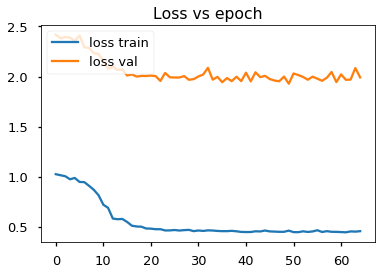

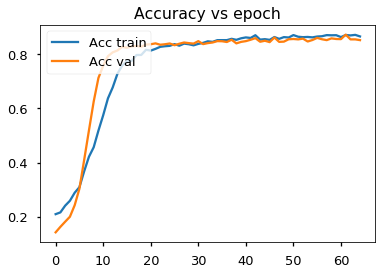

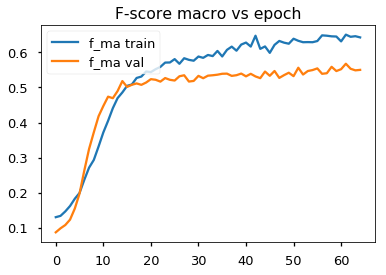

Validación final
Validando Epoch 64
loss_val: tensor(1.9440)
Acc_val: tensor(0.8534, dtype=torch.float64)
f_score_val: tensor(0.5426, dtype=torch.float64)
f_score_val: tensor([0.9170, 0.1811, 0.2266, 0.8455], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.2449, dtype=torch.float64)
f_score_val: tensor([0.7641, 0.0393, 0.0284, 0.1477], dtype=torch.float64)

3.2940392293420614e-05

Validando Epoch 1
f_score_val: tensor(0.2671, dtype=torch.float64)
f_score_val: tensor([0.7799, 0.0368, 0.0416, 0.2101], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 2
f_score_val: tensor(0.3215, dtype=torch.float64)
f_score_val: tensor([0.8029, 0.0425, 0.0327, 0.4080], dtype=torch.float64)

9.882117688026184e-05

Validando Epoch 3
f_score_val: tensor(0.3831, dtype=torch.float64)
f_score_val: tensor([0.8224, 0.0613, 0.03

Validando Epoch 47
f_score_val: tensor(0.4753, dtype=torch.float64)
f_score_val: tensor([0.7953, 0.1235, 0.1522, 0.8303], dtype=torch.float64)

0.0015811388300841895

Validando Epoch 48
f_score_val: tensor(0.3237, dtype=torch.float64)
f_score_val: tensor([0.2430, 0.0830, 0.1310, 0.8377], dtype=torch.float64)

0.00161407922237761

Validando Epoch 49
f_score_val: tensor(0.4570, dtype=torch.float64)
f_score_val: tensor([0.7227, 0.1062, 0.1572, 0.8419], dtype=torch.float64)

0.0016470196146710307

Validando Epoch 50
f_score_val: tensor(0.4196, dtype=torch.float64)
f_score_val: tensor([0.5947, 0.0876, 0.1529, 0.8434], dtype=torch.float64)

0.0016799600069644512

Validando Epoch 51
f_score_val: tensor(0.5074, dtype=torch.float64)
f_score_val: tensor([0.8676, 0.1473, 0.1739, 0.8406], dtype=torch.float64)

0.0017129003992578718

Validando Epoch 52
f_score_val: tensor(0.3990, dtype=torch.float64)
f_score_val: tensor([0.4900, 0.0812, 0.1824, 0.8424], dtype=torch.float64)

0.0017458407915512924



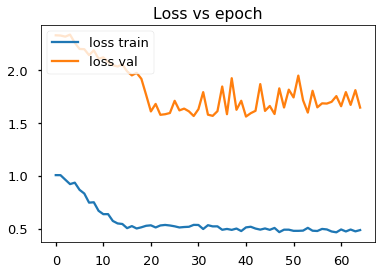

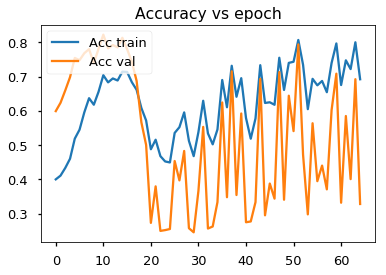

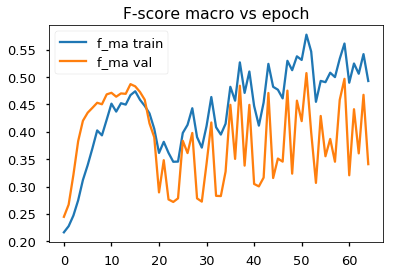

Validación final
Validando Epoch 64
loss_val: tensor(1.6367)
Acc_val: tensor(0.3267, dtype=torch.float64)
f_score_val: tensor(0.3377, dtype=torch.float64)
f_score_val: tensor([0.2418, 0.0767, 0.2082, 0.8240], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 3000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0560, dtype=torch.float64)
f_score_val: tensor([0.0678, 0.0561, 0.0000, 0.1003], dtype=torch.float64)

1.098013076447354e-05

Validando Epoch 1
f_score_val: tensor(0.0580, dtype=torch.float64)
f_score_val: tensor([0.0663, 0.0541, 0.0000, 0.1117], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 2
f_score_val: tensor(0.0674, dtype=torch.float64)
f_score_val: tensor([0.0655, 0.0599, 0.0294, 0.1148], dtype=torch.float64)

3.2940392293420614e-05

Validando Epoch 3
f_score_val: tensor(0.0694, dtype=torch.float64)
f_score_val: tensor([0.0661, 0.0552, 0.01

Validando Epoch 47
f_score_val: tensor(0.3607, dtype=torch.float64)
f_score_val: tensor([0.2610, 0.0846, 0.2571, 0.8402], dtype=torch.float64)

0.0005270462766947298

Validando Epoch 48
f_score_val: tensor(0.3668, dtype=torch.float64)
f_score_val: tensor([0.3481, 0.0918, 0.1926, 0.8345], dtype=torch.float64)

0.0005380264074592034

Validando Epoch 49
f_score_val: tensor(0.3508, dtype=torch.float64)
f_score_val: tensor([0.2573, 0.0852, 0.2252, 0.8355], dtype=torch.float64)

0.0005490065382236769

Validando Epoch 50
f_score_val: tensor(0.3805, dtype=torch.float64)
f_score_val: tensor([0.4021, 0.0843, 0.1998, 0.8360], dtype=torch.float64)

0.0005599866689881504

Validando Epoch 51
f_score_val: tensor(0.3460, dtype=torch.float64)
f_score_val: tensor([0.2027, 0.0795, 0.2604, 0.8412], dtype=torch.float64)

0.0005709667997526239

Validando Epoch 52
f_score_val: tensor(0.3620, dtype=torch.float64)
f_score_val: tensor([0.2935, 0.0847, 0.2276, 0.8423], dtype=torch.float64)

0.0005819469305170975

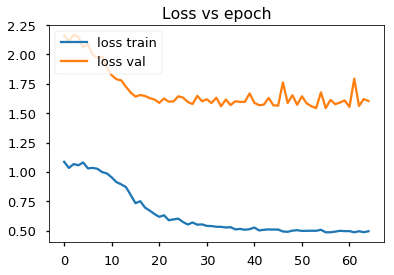

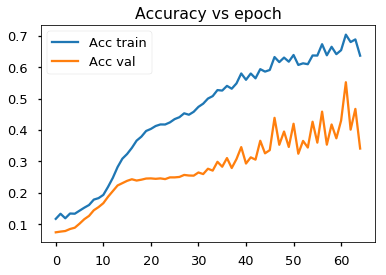

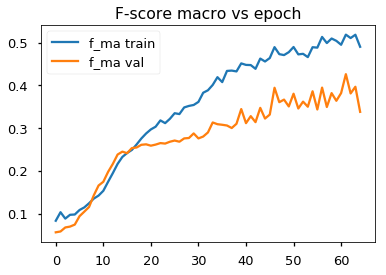

Validación final
Validando Epoch 64
loss_val: tensor(1.5832)
Acc_val: tensor(0.3419, dtype=torch.float64)
f_score_val: tensor(0.3314, dtype=torch.float64)
f_score_val: tensor([0.2381, 0.0787, 0.1632, 0.8455], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 3000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0817, dtype=torch.float64)
f_score_val: tensor([0.1565, 0.0981, 0.0243, 0.0480], dtype=torch.float64)

2.196026152894708e-05

Validando Epoch 1
f_score_val: tensor(0.0887, dtype=torch.float64)
f_score_val: tensor([0.1703, 0.1007, 0.0334, 0.0505], dtype=torch.float64)

4.392052305789416e-05

Validando Epoch 2
f_score_val: tensor(0.1037, dtype=torch.float64)
f_score_val: tensor([0.2110, 0.1041, 0.0378, 0.0618], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 3
f_score_val: tensor(0.1207, dtype=torch.float64)
f_score_val: tensor([0.2589, 0.1010, 0.048

Validando Epoch 47
f_score_val: tensor(0.3737, dtype=torch.float64)
f_score_val: tensor([0.4194, 0.1013, 0.1592, 0.8148], dtype=torch.float64)

0.0010540925533894597

Validando Epoch 48
f_score_val: tensor(0.4358, dtype=torch.float64)
f_score_val: tensor([0.6236, 0.1307, 0.1586, 0.8302], dtype=torch.float64)

0.0010760528149184067

Validando Epoch 49
f_score_val: tensor(0.5089, dtype=torch.float64)
f_score_val: tensor([0.8465, 0.1480, 0.2077, 0.8333], dtype=torch.float64)

0.0010980130764473538

Validando Epoch 50
f_score_val: tensor(0.3905, dtype=torch.float64)
f_score_val: tensor([0.4430, 0.0986, 0.1972, 0.8234], dtype=torch.float64)

0.0011199733379763008

Validando Epoch 51
f_score_val: tensor(0.4541, dtype=torch.float64)
f_score_val: tensor([0.6602, 0.1370, 0.1974, 0.8219], dtype=torch.float64)

0.0011419335995052479

Validando Epoch 52
f_score_val: tensor(0.4476, dtype=torch.float64)
f_score_val: tensor([0.6436, 0.1373, 0.1803, 0.8291], dtype=torch.float64)

0.001163893861034195


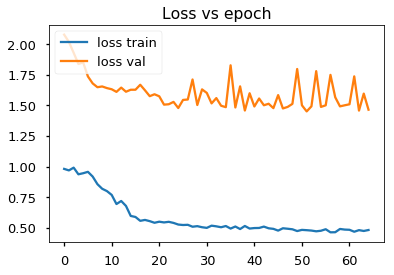

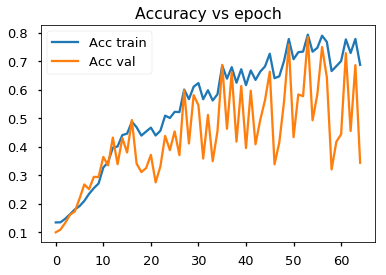

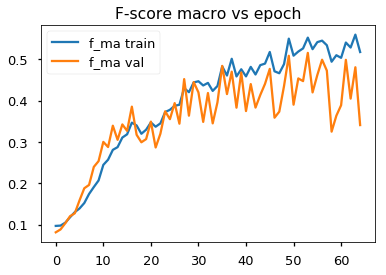

Validación final
Validando Epoch 64
loss_val: tensor(1.4823)
Acc_val: tensor(0.3410, dtype=torch.float64)
f_score_val: tensor(0.3281, dtype=torch.float64)
f_score_val: tensor([0.2726, 0.0902, 0.1336, 0.8161], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 3000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0879, dtype=torch.float64)
f_score_val: tensor([0.1464, 0.0665, 0.0144, 0.1243], dtype=torch.float64)

3.2940392293420614e-05

Validando Epoch 1
f_score_val: tensor(0.0959, dtype=torch.float64)
f_score_val: tensor([0.1807, 0.0519, 0.0124, 0.1386], dtype=torch.float64)

6.588078458684123e-05

Validando Epoch 2
f_score_val: tensor(0.1239, dtype=torch.float64)
f_score_val: tensor([0.2620, 0.0510, 0.0208, 0.1618], dtype=torch.float64)

9.882117688026184e-05

Validando Epoch 3
f_score_val: tensor(0.1570, dtype=torch.float64)
f_score_val: tensor([0.3425, 0.0473, 0.02

Validando Epoch 47
f_score_val: tensor(0.5198, dtype=torch.float64)
f_score_val: tensor([0.8704, 0.2019, 0.1718, 0.8351], dtype=torch.float64)

0.0015811388300841895

Validando Epoch 48
f_score_val: tensor(0.3099, dtype=torch.float64)
f_score_val: tensor([0.2097, 0.0802, 0.1188, 0.8309], dtype=torch.float64)

0.00161407922237761

Validando Epoch 49
f_score_val: tensor(0.4170, dtype=torch.float64)
f_score_val: tensor([0.5774, 0.1123, 0.1462, 0.8321], dtype=torch.float64)

0.0016470196146710307

Validando Epoch 50
f_score_val: tensor(0.4268, dtype=torch.float64)
f_score_val: tensor([0.6305, 0.1289, 0.1104, 0.8374], dtype=torch.float64)

0.0016799600069644512

Validando Epoch 51
f_score_val: tensor(0.3287, dtype=torch.float64)
f_score_val: tensor([0.2384, 0.0856, 0.1504, 0.8402], dtype=torch.float64)

0.0017129003992578718

Validando Epoch 52
f_score_val: tensor(0.4809, dtype=torch.float64)
f_score_val: tensor([0.7818, 0.1534, 0.1590, 0.8297], dtype=torch.float64)

0.0017458407915512924



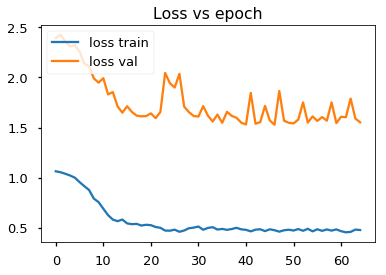

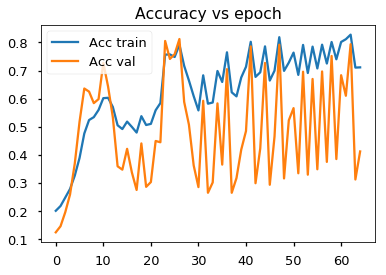

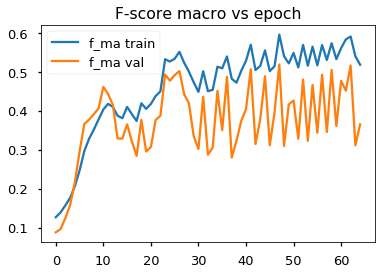

Validación final
Validando Epoch 64
loss_val: tensor(1.5765)
Acc_val: tensor(0.4113, dtype=torch.float64)
f_score_val: tensor(0.3791, dtype=torch.float64)
f_score_val: tensor([0.3969, 0.0981, 0.1891, 0.8321], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1099, dtype=torch.float64)
f_score_val: tensor([0.2017, 0.0147, 0.0242, 0.1988], dtype=torch.float64)

5.103103630798286e-06

Validando Epoch 1
f_score_val: tensor(0.1117, dtype=torch.float64)
f_score_val: tensor([0.2040, 0.0147, 0.0251, 0.2032], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 2
f_score_val: tensor(0.1195, dtype=torch.float64)
f_score_val: tensor([0.2097, 0.0364, 0.0248, 0.2071], dtype=torch.float64)

1.530931089239486e-05

Validando Epoch 3
f_score_val: tensor(0.1241, dtype=torch.float64)
f_score_val: tensor([0.2211, 0.0382, 0.02

Validando Epoch 47
f_score_val: tensor(0.4579, dtype=torch.float64)
f_score_val: tensor([0.9148, 0.2111, 0.1334, 0.5724], dtype=torch.float64)

0.0002449489742783178

Validando Epoch 48
f_score_val: tensor(0.4779, dtype=torch.float64)
f_score_val: tensor([0.9142, 0.1899, 0.1261, 0.6813], dtype=torch.float64)

0.00025005207790911607

Validando Epoch 49
f_score_val: tensor(0.4507, dtype=torch.float64)
f_score_val: tensor([0.9167, 0.1799, 0.1232, 0.5829], dtype=torch.float64)

0.00025515518153991436

Validando Epoch 50
f_score_val: tensor(0.4756, dtype=torch.float64)
f_score_val: tensor([0.9181, 0.1978, 0.1281, 0.6585], dtype=torch.float64)

0.00026025828517071265

Validando Epoch 51
f_score_val: tensor(0.4864, dtype=torch.float64)
f_score_val: tensor([0.9171, 0.2178, 0.1072, 0.7033], dtype=torch.float64)

0.00026536138880151093

Validando Epoch 52
f_score_val: tensor(0.5028, dtype=torch.float64)
f_score_val: tensor([0.9161, 0.2535, 0.1281, 0.7135], dtype=torch.float64)

0.000270464492432

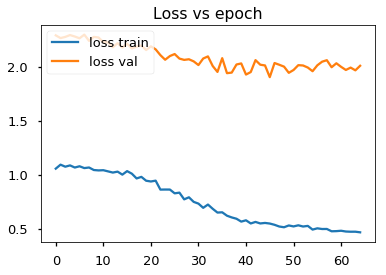

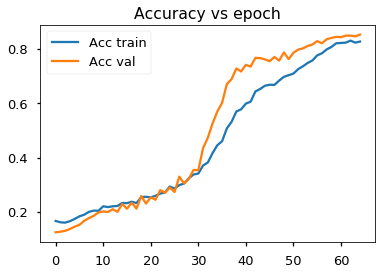

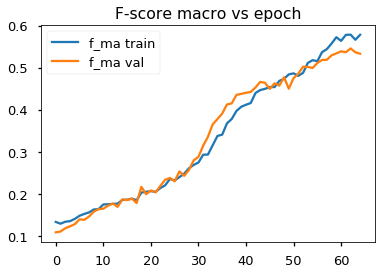

Validación final
Validando Epoch 64
loss_val: tensor(2.0460)
Acc_val: tensor(0.8525, dtype=torch.float64)
f_score_val: tensor(0.5327, dtype=torch.float64)
f_score_val: tensor([0.9220, 0.2051, 0.1798, 0.8238], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.3094, dtype=torch.float64)
f_score_val: tensor([0.7436, 0.0310, 0.0700, 0.3930], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 1
f_score_val: tensor(0.3196, dtype=torch.float64)
f_score_val: tensor([0.7557, 0.0364, 0.0712, 0.4150], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 2
f_score_val: tensor(0.3210, dtype=torch.float64)
f_score_val: tensor([0.7694, 0.0430, 0.0619, 0.4099], dtype=torch.float64)

3.061862178478972e-05

Validando Epoch 3
f_score_val: tensor(0.3366, dtype=torch.float64)
f_score_val: tensor([0.7804, 0.0407, 0.0

Validando Epoch 47
f_score_val: tensor(0.5150, dtype=torch.float64)
f_score_val: tensor([0.8834, 0.1641, 0.1791, 0.8334], dtype=torch.float64)

0.0004898979485566356

Validando Epoch 48
f_score_val: tensor(0.5269, dtype=torch.float64)
f_score_val: tensor([0.9111, 0.2236, 0.1451, 0.8277], dtype=torch.float64)

0.0005001041558182321

Validando Epoch 49
f_score_val: tensor(0.4941, dtype=torch.float64)
f_score_val: tensor([0.8546, 0.1426, 0.1479, 0.8314], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.5161, dtype=torch.float64)
f_score_val: tensor([0.8916, 0.1719, 0.1730, 0.8280], dtype=torch.float64)

0.0005205165703414253

Validando Epoch 51
f_score_val: tensor(0.5372, dtype=torch.float64)
f_score_val: tensor([0.9070, 0.2009, 0.2039, 0.8371], dtype=torch.float64)

0.0005307227776030219

Validando Epoch 52
f_score_val: tensor(0.5138, dtype=torch.float64)
f_score_val: tensor([0.9147, 0.1651, 0.1382, 0.8373], dtype=torch.float64)

0.0005409289848646184

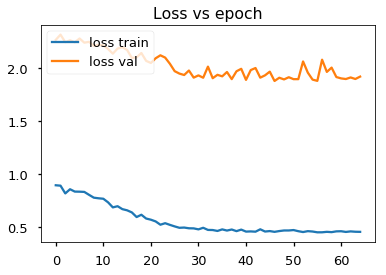

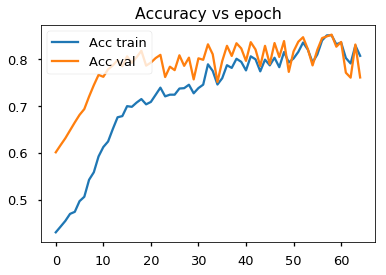

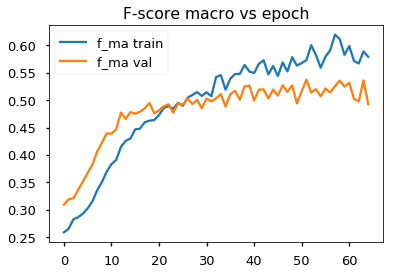

Validación final
Validando Epoch 64
loss_val: tensor(1.9322)
Acc_val: tensor(0.7610, dtype=torch.float64)
f_score_val: tensor(0.4934, dtype=torch.float64)
f_score_val: tensor([0.8438, 0.1395, 0.1570, 0.8332], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 128  batch_size: 128  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1763, dtype=torch.float64)
f_score_val: tensor([0.0973, 0.0314, 0.0290, 0.5476], dtype=torch.float64)

1.5309310892394858e-05

Validando Epoch 1
f_score_val: tensor(0.1825, dtype=torch.float64)
f_score_val: tensor([0.1093, 0.0401, 0.0270, 0.5537], dtype=torch.float64)

3.0618621784789716e-05

Validando Epoch 2
f_score_val: tensor(0.1906, dtype=torch.float64)
f_score_val: tensor([0.1142, 0.0510, 0.0303, 0.5670], dtype=torch.float64)

4.5927932677184585e-05

Validando Epoch 3
f_score_val: tensor(0.1954, dtype=torch.float64)
f_score_val: tensor([0.1194, 0.0690, 0.

Validando Epoch 47
f_score_val: tensor(0.5375, dtype=torch.float64)
f_score_val: tensor([0.9260, 0.1410, 0.2542, 0.8290], dtype=torch.float64)

0.0007348469228349534

Validando Epoch 48
f_score_val: tensor(0.5283, dtype=torch.float64)
f_score_val: tensor([0.9218, 0.1629, 0.2158, 0.8128], dtype=torch.float64)

0.0007501562337273482

Validando Epoch 49
f_score_val: tensor(0.5335, dtype=torch.float64)
f_score_val: tensor([0.9237, 0.1527, 0.2460, 0.8114], dtype=torch.float64)

0.0007654655446197431

Validando Epoch 50
f_score_val: tensor(0.5335, dtype=torch.float64)
f_score_val: tensor([0.9229, 0.1641, 0.2219, 0.8252], dtype=torch.float64)

0.0007807748555121379

Validando Epoch 51
f_score_val: tensor(0.5448, dtype=torch.float64)
f_score_val: tensor([0.9247, 0.2081, 0.2260, 0.8205], dtype=torch.float64)

0.0007960841664045328

Validando Epoch 52
f_score_val: tensor(0.5296, dtype=torch.float64)
f_score_val: tensor([0.9274, 0.1829, 0.1784, 0.8296], dtype=torch.float64)

0.0008113934772969277

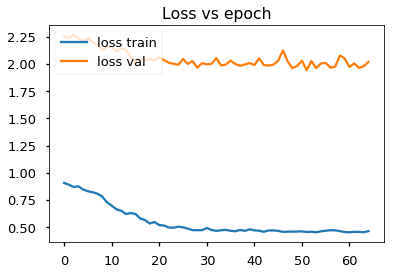

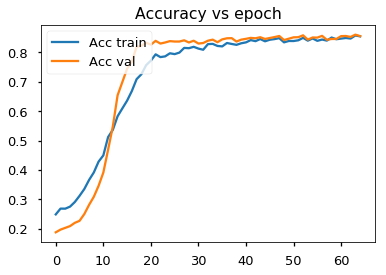

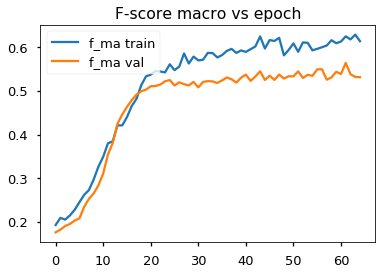

Validación final
Validando Epoch 64
loss_val: tensor(2.0199)
Acc_val: tensor(0.8562, dtype=torch.float64)
f_score_val: tensor(0.5335, dtype=torch.float64)
f_score_val: tensor([0.9250, 0.1454, 0.2288, 0.8346], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 5000  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0356, dtype=torch.float64)
f_score_val: tensor([0.0313, 0.0603, 0.0343, 0.0165], dtype=torch.float64)

5.103103630798286e-06

Validando Epoch 1
f_score_val: tensor(0.0360, dtype=torch.float64)
f_score_val: tensor([0.0298, 0.0642, 0.0342, 0.0159], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 2
f_score_val: tensor(0.0381, dtype=torch.float64)
f_score_val: tensor([0.0302, 0.0691, 0.0369, 0.0161], dtype=torch.float64)

1.530931089239486e-05

Validando Epoch 3
f_score_val: tensor(0.0370, dtype=torch.float64)
f_score_val: tensor([0.0299, 0.0667, 0.03

Validando Epoch 47
f_score_val: tensor(0.3685, dtype=torch.float64)
f_score_val: tensor([0.4617, 0.1050, 0.1754, 0.7320], dtype=torch.float64)

0.0002449489742783178

Validando Epoch 48
f_score_val: tensor(0.3965, dtype=torch.float64)
f_score_val: tensor([0.5442, 0.1161, 0.1903, 0.7353], dtype=torch.float64)

0.00025005207790911607

Validando Epoch 49
f_score_val: tensor(0.3686, dtype=torch.float64)
f_score_val: tensor([0.4636, 0.1109, 0.1819, 0.7179], dtype=torch.float64)

0.00025515518153991436

Validando Epoch 50
f_score_val: tensor(0.4124, dtype=torch.float64)
f_score_val: tensor([0.6328, 0.1049, 0.1681, 0.7437], dtype=torch.float64)

0.00026025828517071265

Validando Epoch 51
f_score_val: tensor(0.3630, dtype=torch.float64)
f_score_val: tensor([0.4381, 0.0974, 0.1845, 0.7319], dtype=torch.float64)

0.00026536138880151093

Validando Epoch 52
f_score_val: tensor(0.3871, dtype=torch.float64)
f_score_val: tensor([0.4931, 0.1069, 0.2023, 0.7460], dtype=torch.float64)

0.000270464492432

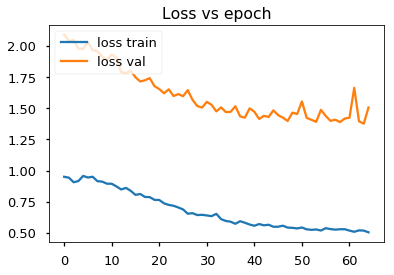

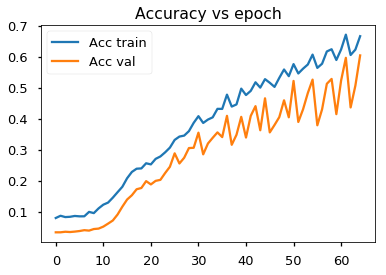

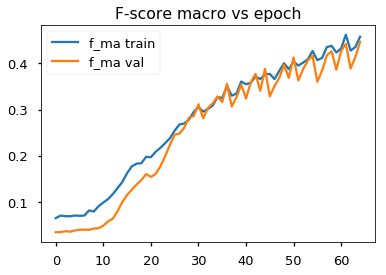

Validación final
Validando Epoch 64
loss_val: tensor(1.4986)
Acc_val: tensor(0.6062, dtype=torch.float64)
f_score_val: tensor(0.4552, dtype=torch.float64)
f_score_val: tensor([0.7207, 0.1290, 0.2063, 0.7650], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 5000  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.1992, dtype=torch.float64)
f_score_val: tensor([0.2469, 0.0673, 0.0235, 0.4593], dtype=torch.float64)

1.0206207261596573e-05

Validando Epoch 1
f_score_val: tensor(0.2041, dtype=torch.float64)
f_score_val: tensor([0.2479, 0.0673, 0.0246, 0.4765], dtype=torch.float64)

2.0412414523193145e-05

Validando Epoch 2
f_score_val: tensor(0.2191, dtype=torch.float64)
f_score_val: tensor([0.2646, 0.0725, 0.0257, 0.5135], dtype=torch.float64)

3.061862178478972e-05

Validando Epoch 3
f_score_val: tensor(0.2259, dtype=torch.float64)
f_score_val: tensor([0.2723, 0.0694, 0.0

Validando Epoch 47
f_score_val: tensor(0.4389, dtype=torch.float64)
f_score_val: tensor([0.6797, 0.1181, 0.1349, 0.8229], dtype=torch.float64)

0.0004898979485566356

Validando Epoch 48
f_score_val: tensor(0.4809, dtype=torch.float64)
f_score_val: tensor([0.8430, 0.1267, 0.1444, 0.8094], dtype=torch.float64)

0.0005001041558182321

Validando Epoch 49
f_score_val: tensor(0.4157, dtype=torch.float64)
f_score_val: tensor([0.6085, 0.0914, 0.1400, 0.8228], dtype=torch.float64)

0.0005103103630798287

Validando Epoch 50
f_score_val: tensor(0.4527, dtype=torch.float64)
f_score_val: tensor([0.7119, 0.1021, 0.1684, 0.8283], dtype=torch.float64)

0.0005205165703414253

Validando Epoch 51
f_score_val: tensor(0.4731, dtype=torch.float64)
f_score_val: tensor([0.7675, 0.1353, 0.1718, 0.8177], dtype=torch.float64)

0.0005307227776030219

Validando Epoch 52
f_score_val: tensor(0.5041, dtype=torch.float64)
f_score_val: tensor([0.8625, 0.1578, 0.1690, 0.8271], dtype=torch.float64)

0.0005409289848646184

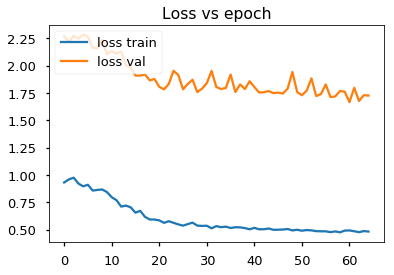

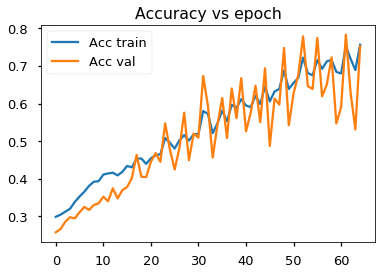

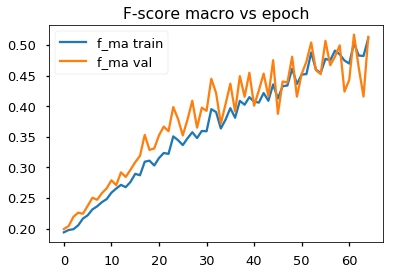

Validación final
Validando Epoch 64
loss_val: tensor(1.7653)
Acc_val: tensor(0.7523, dtype=torch.float64)
f_score_val: tensor(0.5148, dtype=torch.float64)
f_score_val: tensor([0.8336, 0.1769, 0.2150, 0.8338], dtype=torch.float64)


Entrenando modelo D: 0.2  h_dim: 256  batch_size: 128  fase: 5000  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.0825, dtype=torch.float64)
f_score_val: tensor([0.1789, 0.0427, 0.0451, 0.0633], dtype=torch.float64)

1.5309310892394858e-05

Validando Epoch 1
f_score_val: tensor(0.0866, dtype=torch.float64)
f_score_val: tensor([0.1852, 0.0491, 0.0421, 0.0701], dtype=torch.float64)

3.0618621784789716e-05

Validando Epoch 2
f_score_val: tensor(0.0883, dtype=torch.float64)
f_score_val: tensor([0.1918, 0.0505, 0.0398, 0.0710], dtype=torch.float64)

4.5927932677184585e-05

Validando Epoch 3
f_score_val: tensor(0.0905, dtype=torch.float64)
f_score_val: tensor([0.1963, 0.0619, 0.

Validando Epoch 47
f_score_val: tensor(0.3281, dtype=torch.float64)
f_score_val: tensor([0.2698, 0.0924, 0.1608, 0.7895], dtype=torch.float64)

0.0007348469228349534

Validando Epoch 48
f_score_val: tensor(0.4506, dtype=torch.float64)
f_score_val: tensor([0.6930, 0.1277, 0.1811, 0.8004], dtype=torch.float64)

0.0007501562337273482

Validando Epoch 49
f_score_val: tensor(0.3079, dtype=torch.float64)
f_score_val: tensor([0.1736, 0.0812, 0.1660, 0.8108], dtype=torch.float64)

0.0007654655446197431

Validando Epoch 50
f_score_val: tensor(0.3588, dtype=torch.float64)
f_score_val: tensor([0.3369, 0.0967, 0.1932, 0.8085], dtype=torch.float64)

0.0007807748555121379

Validando Epoch 51
f_score_val: tensor(0.4287, dtype=torch.float64)
f_score_val: tensor([0.5959, 0.1259, 0.1688, 0.8242], dtype=torch.float64)

0.0007960841664045328

Validando Epoch 52
f_score_val: tensor(0.4586, dtype=torch.float64)
f_score_val: tensor([0.7378, 0.1405, 0.1637, 0.7924], dtype=torch.float64)

0.0008113934772969277

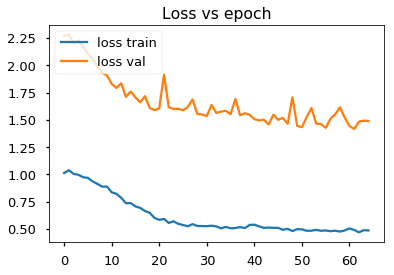

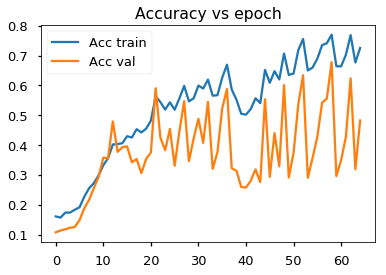

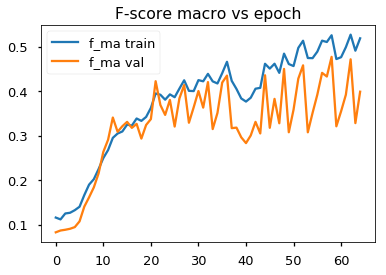

Validación final
Validando Epoch 64
loss_val: tensor(1.4994)
Acc_val: tensor(0.4835, dtype=torch.float64)
f_score_val: tensor(0.4017, dtype=torch.float64)
f_score_val: tensor([0.5489, 0.1207, 0.1447, 0.7925], dtype=torch.float64)


Entrenando modelo D: 0.3  h_dim: 128  batch_size: 32  fase: 500  factor: 1

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4136, dtype=torch.float64)
f_score_val: tensor([0.8590, 0.0358, 0.0000, 0.7595], dtype=torch.float64)

0.0006454972243679028

Validando Epoch 1
f_score_val: tensor(0.4628, dtype=torch.float64)
f_score_val: tensor([0.9151, 0.0644, 0.0348, 0.8369], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 2
f_score_val: tensor(0.4649, dtype=torch.float64)
f_score_val: tensor([0.9235, 0.0831, 0.0338, 0.8194], dtype=torch.float64)

0.001473139127471974

Validando Epoch 3
f_score_val: tensor(0.4647, dtype=torch.float64)
f_score_val: tensor([0.9284, 0.0731, 0.0493, 

Validando Epoch 47
f_score_val: tensor(0.4867, dtype=torch.float64)
f_score_val: tensor([0.9309, 0.0881, 0.0856, 0.8424], dtype=torch.float64)

0.0003682847818679935

Validando Epoch 48
f_score_val: tensor(0.4919, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.1045, 0.0930, 0.8388], dtype=torch.float64)

0.00036450740219987765

Validando Epoch 49
f_score_val: tensor(0.4848, dtype=torch.float64)
f_score_val: tensor([0.9308, 0.0955, 0.0766, 0.8361], dtype=torch.float64)

0.00036084391824351607

Validando Epoch 50
f_score_val: tensor(0.4934, dtype=torch.float64)
f_score_val: tensor([0.9315, 0.0970, 0.0980, 0.8472], dtype=torch.float64)

0.0003572887190468934

Validando Epoch 51
f_score_val: tensor(0.4847, dtype=torch.float64)
f_score_val: tensor([0.9313, 0.0771, 0.0881, 0.8423], dtype=torch.float64)

0.0003538365731701862

Validando Epoch 52
f_score_val: tensor(0.4853, dtype=torch.float64)
f_score_val: tensor([0.9309, 0.0905, 0.0846, 0.8353], dtype=torch.float64)

0.00035048259630752

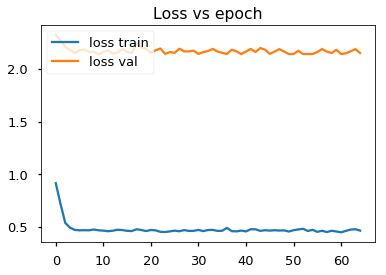

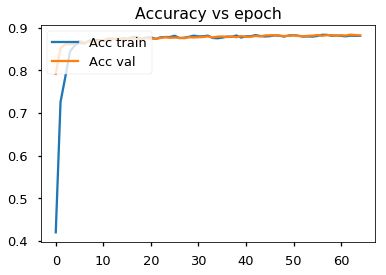

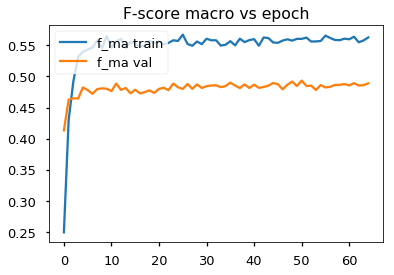

Validación final
Validando Epoch 64
loss_val: tensor(2.1413)
Acc_val: tensor(0.8811, dtype=torch.float64)
f_score_val: tensor(0.4825, dtype=torch.float64)
f_score_val: tensor([0.9318, 0.0741, 0.0806, 0.8434], dtype=torch.float64)


Entrenando modelo D: 0.3  h_dim: 128  batch_size: 32  fase: 500  factor: 2

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4706, dtype=torch.float64)
f_score_val: tensor([0.9288, 0.0905, 0.0274, 0.8356], dtype=torch.float64)

0.0012909944487358056

Validando Epoch 1
f_score_val: tensor(0.4836, dtype=torch.float64)
f_score_val: tensor([0.9264, 0.0891, 0.0933, 0.8254], dtype=torch.float64)

0.0025819888974716113

Validando Epoch 2
f_score_val: tensor(0.4780, dtype=torch.float64)
f_score_val: tensor([0.9241, 0.0905, 0.0682, 0.8293], dtype=torch.float64)

0.002946278254943948

Validando Epoch 3
f_score_val: tensor(0.4782, dtype=torch.float64)
f_score_val: tensor([0.9069, 0.1222, 0.0468, 

Validando Epoch 47
f_score_val: tensor(0.4884, dtype=torch.float64)
f_score_val: tensor([0.9272, 0.1139, 0.0667, 0.8460], dtype=torch.float64)

0.000736569563735987

Validando Epoch 48
f_score_val: tensor(0.4920, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.1299, 0.0607, 0.8480], dtype=torch.float64)

0.0007290148043997553

Validando Epoch 49
f_score_val: tensor(0.4940, dtype=torch.float64)
f_score_val: tensor([0.9307, 0.1438, 0.0637, 0.8380], dtype=torch.float64)

0.0007216878364870321

Validando Epoch 50
f_score_val: tensor(0.4899, dtype=torch.float64)
f_score_val: tensor([0.9302, 0.1060, 0.0796, 0.8439], dtype=torch.float64)

0.0007145774380937868

Validando Epoch 51
f_score_val: tensor(0.4916, dtype=torch.float64)
f_score_val: tensor([0.9316, 0.1090, 0.0821, 0.8439], dtype=torch.float64)

0.0007076731463403724

Validando Epoch 52
f_score_val: tensor(0.4882, dtype=torch.float64)
f_score_val: tensor([0.9293, 0.1194, 0.0647, 0.8392], dtype=torch.float64)

0.0007009651926150552


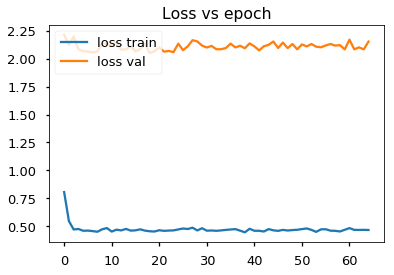

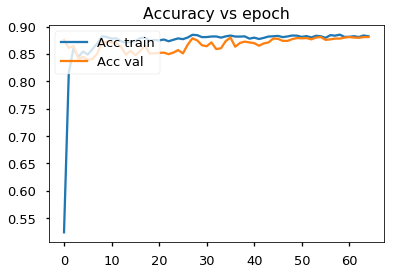

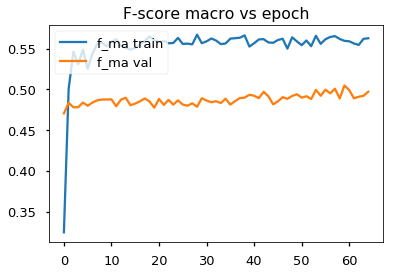

Validación final
Validando Epoch 64
loss_val: tensor(2.1190)
Acc_val: tensor(0.8815, dtype=torch.float64)
f_score_val: tensor(0.4929, dtype=torch.float64)
f_score_val: tensor([0.9325, 0.1303, 0.0697, 0.8392], dtype=torch.float64)


Entrenando modelo D: 0.3  h_dim: 128  batch_size: 32  fase: 500  factor: 3

tensor([ 0.4353, 28.9727, 20.9671,  0.6172])
Creando modelo con salida Softmax

0

Validando Epoch 0
f_score_val: tensor(0.4501, dtype=torch.float64)
f_score_val: tensor([0.9291, 0.0075, 0.0383, 0.8253], dtype=torch.float64)

0.0019364916731037084

Validando Epoch 1
f_score_val: tensor(0.4794, dtype=torch.float64)
f_score_val: tensor([0.9214, 0.0866, 0.0706, 0.8392], dtype=torch.float64)

0.003872983346207417

Validando Epoch 2
f_score_val: tensor(0.4803, dtype=torch.float64)
f_score_val: tensor([0.9218, 0.1114, 0.0582, 0.8297], dtype=torch.float64)

0.004419417382415922

Validando Epoch 3
f_score_val: tensor(0.4832, dtype=torch.float64)
f_score_val: tensor([0.9290, 0.0871, 0.0771, 0

In [ ]:
drops= [0.2, 0.3, 0.4]
h_dims= [128, 256]
fases= [500,3000,5000]
factores= [1,2,3]
batches= [32,64,128]

for drop in drops:
    for batch in batches:
        for fase in fases:
            for h_dim in h_dims:
                for factor in factores:
                    print ("")
                    print ("")
                    print ("Entrenando modelo D:",drop, " h_dim:",h_dim," batch_size:",batch," fase:",fase," factor:",factor)
                    print ("")
                    V = 4
                    pesos = torch.from_numpy(class_weights).float()
                    print (pesos)
                    criterion = FocalLoss(weights=pesos)
                    model = make_model_concat(4, N=2,d_model=768, d_ff=h_dim, h=4, dropout=drop)
                    model_opt = NoamOpt(model.src_embed[0].d_model, factor, fase, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

                    hist_train_loss=[]
                    hist_train_acc=[]
                    hist_train_fma=[]
                    hist_val_loss=[]
                    hist_val_acc=[]
                    hist_val_fma=[]

                    for epoch in range(65):
                        print ("")
                        print (model_opt._rate)
                        print ("")
                        model.train()
                        DATA=data_gen(batch, 'Train', 4, new_matrix)
                        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')
                        hist_train_loss.append(loss_train)
                        hist_train_acc.append(acc_train)
                        hist_train_fma.append(fma_train)

                        model.eval()
                        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(batch, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
                        print ("Validando Epoch",epoch)
                        #print ("loss_val:",loss_val)
                        #print ("Acc_val:",acc_val)
                        print ("f_score_val:",fma_val)
                        print ("f_score_val:",f_val_none)
                        hist_val_loss.append(loss_val)
                        hist_val_acc.append(acc_val)
                        hist_val_fma.append(fma_val)

                    #####################################3
                    plt.plot(hist_train_loss, label='loss train')
                    plt.plot(hist_val_loss,label='loss val')
                    plt.legend(loc='upper left')
                    plt.title("Loss vs epoch")
                    plt.show()

                    plt.plot(hist_train_acc, label='Acc train')
                    plt.plot(hist_val_acc, label='Acc val')
                    plt.legend(loc='upper left')
                    plt.title("Accuracy vs epoch")
                    plt.show()

                    plt.plot(hist_train_fma, label='f_ma train')
                    plt.plot(hist_val_fma, label='f_ma val')
                    plt.legend(loc='upper left')
                    plt.title("F-score macro vs epoch")
                    plt.show()

                    ####################################
                    model.eval()
                    print ("Validación final")
                    loss_val, acc_val,fma_val, f_val_none, cm_val = run_epoch(data_gen(batch, 'Val', 4, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
                    print ("Validando Epoch",epoch)
                    print ("loss_val:",loss_val)
                    print ("Acc_val:",acc_val)
                    print ("f_score_val:",fma_val)
                    print ("f_score_val:",f_val_none)